<a href="https://colab.research.google.com/github/HyberionBrew/skylab_change_prediction/blob/main/net_building_double.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls 

drive  sample_data


In [3]:
!cp drive/MyDrive/Skylab/dataset_middle.zip dataset_middle.zip

In [4]:
%%capture
!unzip dataset_middle.zip

In [5]:
!ls dataset

after  after_label  before  before_label  diff_label  middle  middle_label


In [6]:
#!cp drive/MyDrive/dataset.zip dataset.zip

In [7]:
%%capture
!pip install rasterio
!pip install geopandas
!pip install albumentations==0.4.6

In [8]:
# the precision, dice ... metrics
!git clone https://github.com/hsiangyuzhao/Segmentation-Metrics-PyTorch.git

Cloning into 'Segmentation-Metrics-PyTorch'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [9]:
!cp Segmentation-Metrics-PyTorch/metric.py metric.py

In [10]:
from metric import BinaryMetrics

In [11]:
!git clone https://github.com/milesial/Pytorch-UNet

Cloning into 'Pytorch-UNet'...
remote: Enumerating objects: 530, done.
remote: Total 530 (delta 0), reused 0 (delta 0), pack-reused 530
Receiving objects: 100% (530/530), 47.40 MiB | 18.38 MiB/s, done.
Resolving deltas: 100% (276/276), done.


In [12]:
!cp -r Pytorch-UNet/unet/ unet/

In [13]:
import sys
import os
sys.path.append(os.path.abspath("unet/*"))
from unet.unet_parts import *
from unet.unet_model import UNet

In [14]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import rasterio as rio
from rasterio import features
from pathlib import Path
import pathlib
import geopandas as gpd
from descartes import PolygonPatch
from PIL import Image
import itertools
import re
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# import imgaug
import random
import albumentations

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

%matplotlib inline

In [15]:
import cv2

In [16]:
total_indx = 2
img1 = cv2.imread('./dataset/before/%06d.png'%total_indx)
img2 = cv2.imread('./dataset/after/%06d.png'%total_indx)
mask1 = torch.load('./dataset/before_label/%06d.pth'%total_indx)
mask2 = torch.load('./dataset/after_label/%06d.pth'%total_indx)
mask_diff = torch.load('./dataset/diff_label/%06d.pth'%total_indx)

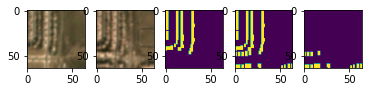

In [17]:
# plt.figure(figsize=(4, 4), dpi=80)
plt.subplot(2, 5, 1)
plt.imshow(img1)

plt.subplot(2, 5, 2)
plt.imshow(img2)

plt.subplot(2, 5, 3)
plt.imshow(mask1)

plt.subplot(2, 5, 4)
plt.imshow(mask2)
plt.subplot(2, 5, 5)
plt.imshow(mask_diff)

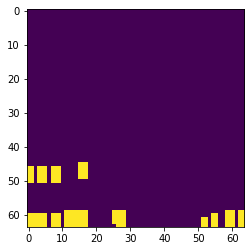

In [18]:
#%%
plt.imshow(mask_diff)

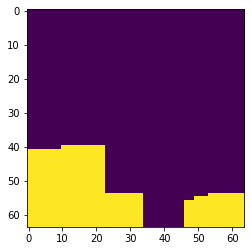

In [19]:
plt.imshow(cv2.GaussianBlur(mask_diff.astype(float),(11, 11), 0) > 0.)

In [20]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [21]:
#%%
import glob

In [22]:
paths = glob.glob('./dataset/before/*')
!ls dataset/

after  after_label  before  before_label  diff_label  middle  middle_label


In [23]:
!mkdir dataset/middle_after_diff
!ls dataset

after	     before	   diff_label  middle_after_diff
after_label  before_label  middle      middle_label


In [24]:
# compute diff label from middle to after
path_middle = glob.glob('./dataset/middle_label/*')
path_after = glob.glob('./dataset/after_label/*')
assert(len(path_middle)==len(path_after))
for i in range(len(path_middle)):
    middle_label = torch.load(path_middle[i])
    after_label = torch.load(path_after[i])
    middle_after_diff = np.logical_xor(middle_label,after_label).astype(np.uint8)
    save_path = str(path_middle[i].replace('middle_label','middle_after_diff'))
    torch.save(middle_after_diff,save_path)

print(f"generated: {len(glob.glob('./dataset/middle_after_diff/*'))}")

generated: 5055


In [68]:
class MyDataset(Dataset):
    def __init__(self, transform=None):
        self.paths = glob.glob('./dataset/before/*')
        self.transform = transform
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_before = cv2.imread(self.paths[idx])
        img_middle = cv2.imread(self.paths[idx].replace('before','middle'))
        img_after = cv2.imread(self.paths[idx].replace('before','after'))

        label_diff_before = torch.load(self.paths[idx].replace('before','diff_label').replace('png','pth'))
        gt_diff_middle = torch.load(self.paths[idx].replace('before','middle_after_diff').replace('png','pth'))
        #label_middle = torch.load(self.paths[idx].replace('before','diff_label').replace('png','pth'))
        # why do we use label2 here?
        #label1 = torch.load(self.paths[idx].replace('before','before_label').replace('png','pth')) 
        label_interest = cv2.GaussianBlur(gt_diff_middle.astype(float),(11, 11), 0) > 0.
        #label1 = cv2.GaussianBlur(label2.astype(float),(11, 11), 0) > 0.
        if self.transform:
            transformed1 = self.transform(image = img_before,label = label_diff_before)
            transformed2 = self.transform(image = img_middle,label = label_interest)
            transformed3 = self.transform(image = img_after,label = gt_diff_middle)
        img_before = transformed1['image']
        label_diff_before = transformed1['label']
        img_middle = transformed2['image']
        label_interest = transformed2['label']
        img_after = transformed3['image']
        gt_diff_middle = transformed3['label']
        return img_before,img_middle,img_after, label_interest,label_diff_before ,gt_diff_middle


In [69]:
transform = A.Compose(
    [
        A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2()
    ]
)

In [70]:
dataset = MyDataset(transform)
img_before,img_middle,img_after, label_interest,gt_diff_before ,gt_diff_middle = dataset[2000]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


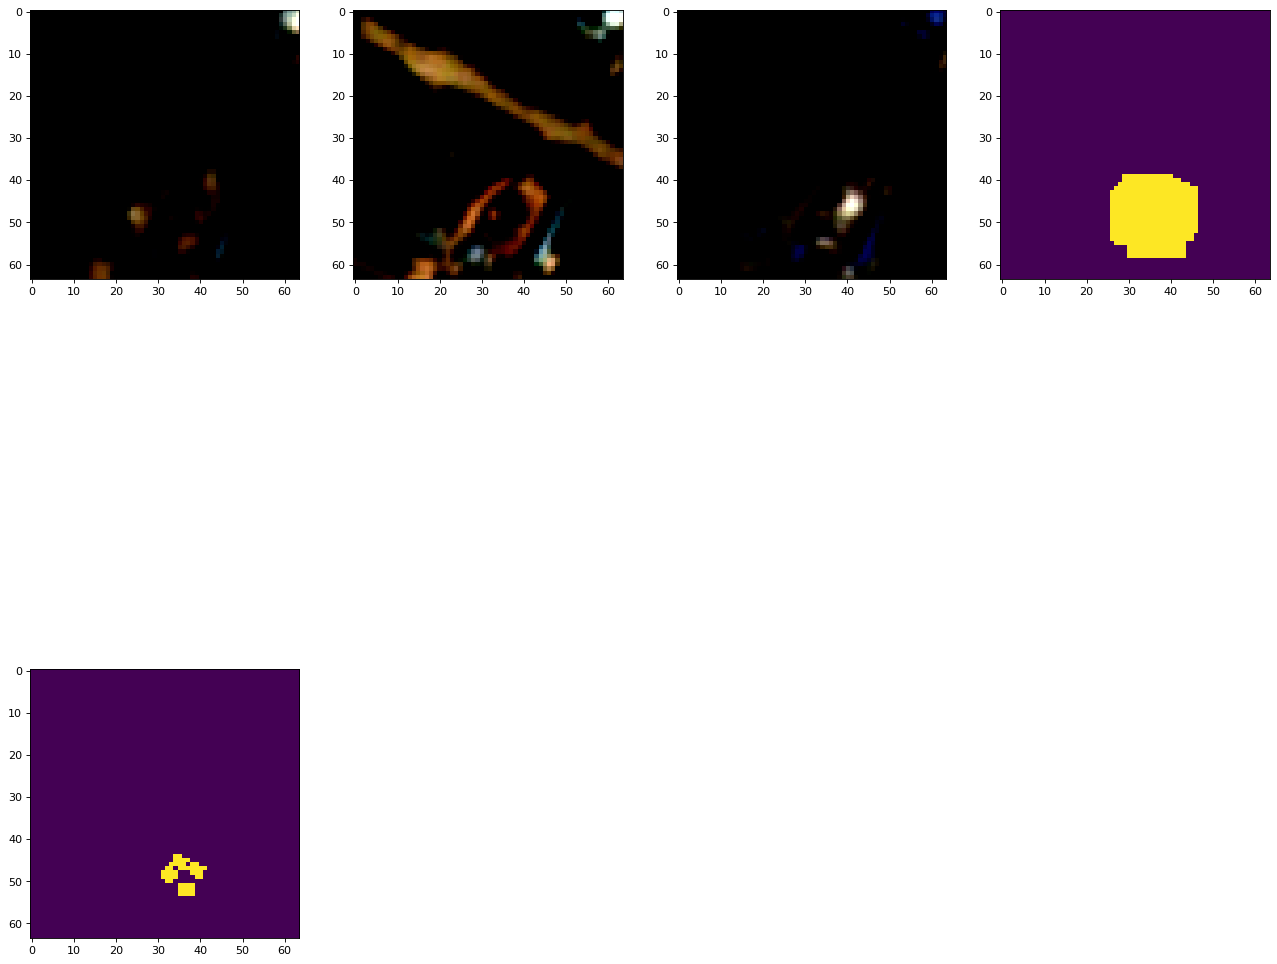

In [71]:
plt.figure(figsize=(20, 20), dpi=80)
plt.subplot(2, 4, 1)
plt.imshow(img_before.permute(1,2,0))

plt.subplot(2, 4, 2)
plt.imshow(img_middle.permute(1,2,0))

plt.subplot(2, 4, 3)
plt.imshow(img_after.permute(1,2,0))

plt.subplot(2, 4, 4)
plt.imshow(label_interest)
plt.subplot(2, 4, 5)
plt.imshow(gt_diff_middle)

In [72]:
from torch.utils.data.sampler import SubsetRandomSampler
import math

train_size = math.floor(0.8 * len(dataset))
test_size = len(dataset)- train_size

np.random.seed(42)
indices = list(range(len(dataset)))
np.random.shuffle(indices)
val_indices,train_indices = indices[train_size:], indices[:train_size]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(val_indices)

batch_size = 32
num_workers = 3
train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
test_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=test_sampler, num_workers=num_workers)

In [73]:
import torch
import numpy as np

import torchvision.transforms.functional as visionF


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs, label):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    plt.title(label)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = visionF.to_pil_image(img)
        img_gray = np.mean(img, axis=2)
        axs[0, i].imshow(np.asarray(img_gray),cmap=plt.get_cmap('RdYlGn'))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [74]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
def show_batch_images(examples, amount:int, label):
    grid = make_grid(examples)
    show(grid ,label)

In [75]:
#dataloader = DataLoader(dataset, batch_size=8,
#                        shuffle=False, num_workers=3)

In [76]:
def metric(outputs: torch.Tensor, labels: torch.Tensor):
    # y_true: (N, H, W)
    # y_pred: (N, 1, H, W)
    bn = BinaryMetrics()
    metrics = bn(labels,outputs)
    #print(metrics)
    return metrics

In [77]:
!ls 

dataset		    metric.py	  sample_data			utils
dataset_middle.zip  __pycache__   Segmentation-Metrics-PyTorch
drive		    Pytorch-UNet  unet


In [39]:
!mkdir utils
!cp -r Pytorch-UNet/utils/ .
!ls utils


mkdir: cannot create directory ‘utils’: File exists
data_loading.py  dice_score.py	__init__.py  utils.py


In [150]:
from utils.dice_score import dice_loss
pixel_acc_all = []
dice_all = [] 
precision_all = [] 
specificity_all = [] 
recall_all = []

def test_loop(model, test_dataset):
    computeExample = True
    example = np.zeros((batch_size,64,64))
    example_label = torch.tensor(np.zeros((batch_size,64,64)))
    input_label = None
    for img_before,img_middle,img_after, label_interest,gt_diff_before ,gt_diff_middle in tqdm(test_dataset):
        img_before = img_before.type(torch.float32).cuda()
        img_middle = img_middle.type(torch.float32).cuda()
        #img_after = img_after.type(torch.float32).cuda()
        # enable the below to see results with complete input mask
        #label_interest = torch.tensor(np.ones_like(label_interest))
        label_interest = label_interest.cuda()
        #gt_diff_middle = gt_diff_middle.cuda()
        gt_diff_before = gt_diff_middle.cuda()
        with torch.no_grad():
            #sig = torch.nn.Sigmoid()
            
            output = model(torch.cat([img_before,label_interest.unsqueeze(1).type(torch.float32)],dim=1),
                           torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))
            out_mask = output#output[:,-1,:,:]
            #print(f"outmask {out_mask.shape}")
            #out_mask = sig(out_mask.unsqueeze(1))
        #out_image = output[:,:-1,:,:]
       
         # torch.nn.functional.softmax(out_mask, dim=)
        final_mask = out_mask.cpu() #.detach().numpy()
        #print(f"outmask {final_mask.shape}")
        #final_mask = np.zeros_like(det_mask)
        #final_mask[det_mask>0.5] = 1
        
        pixel_acc, dice, precision, specificity, recall = metric(final_mask,gt_diff_middle.cpu())
        
        pixel_acc_all.append(float(pixel_acc.data.cpu()))
        dice_all.append(float(dice.data.cpu()))
        precision_all.append(float(precision.data.cpu()))
        specificity_all.append(float(specificity.data.cpu()))
        recall_all.append(float(recall.data.cpu()))

        # compute example
        if computeExample:
            sig = torch.nn.Sigmoid()
            final_mask = sig(final_mask)
            final_mask = final_mask.cpu().detach().numpy()
            
            example = np.zeros_like(final_mask)
            #print("----")
            #print(example.shape)
            example[final_mask>0.5] = 1
            computeExample = False
            example_label = gt_diff_middle.unsqueeze(1).cpu()
            input_label = label_interest.unsqueeze(1).cpu()

        
    means = [np.mean(pixel_acc_all), np.mean(dice_all), np.mean(precision_all), np.mean(specificity_all),np.mean(recall_all)]
    print(f"Pixel acc {means[0]}; Dice {means[1]}; Precision {means[2]}; Specifity {means[3]}; Recall{means[4]}")
    #print(example.shape)
    #print("dwd")
    return means, torch.tensor(example), example_label, input_label
        


In [151]:
import torch.nn.functional as F
from utils.dice_score import dice_loss
losses = []
examples = []
metrics_all = []

In [152]:
import torch.nn as nn
from unet.unet_parts import *

class UNet_double_down(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet_double_down, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        
        self.inc_2 = DoubleConv(n_channels, 64)
        self.down1_2 = Down(64, 128)
        self.down2_2 = Down(128, 256)
        self.down3_2 = Down(256, 512)
        self.down4_2 = Down(512, 1024 // factor)

        self.combine1 = nn.Conv2d(128,64,2,padding="same")
        self.combine2 = nn.Conv2d(256,128,2,padding="same")
        self.combine3 = nn.Conv2d(512,256,2,padding="same")
        self.combine4 =nn.Conv2d(1024,512,2,padding="same")
        self.combine5 =nn.Conv2d(2048,1024 // factor,2,padding="same")
        
        
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)


    def forward(self, before, between):
        x1 = self.inc(before)
        #64 channels
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x1_2 = self.inc_2(between)
        x2_2 = self.down1_2(x1_2)
        x3_2 = self.down2_2(x2_2)
        x4_2 = self.down3_2(x3_2)
        x5_2 = self.down4_2(x4_2)
        dim = 1
        #print(x1.shape)
        #print(torch.cat((x1,x1_2),dim=dim).shape)
        x1 = self.combine1(torch.cat((x1,x1_2),dim=dim))
        #print(x1.shape)
        x2 = self.combine2(torch.cat((x2,x2_2),dim=dim))
        x3 = self.combine3(torch.cat((x3,x3_2),dim=dim))
        x4 = self.combine4(torch.cat((x4,x4_2),dim=dim))
        x5 = self.combine5(torch.cat((x5,x5_2),dim=dim))

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [153]:
model2 = UNet_double_down(4,1)
model2.eval()
im1 = torch.ones([1,4,64, 64], dtype=torch.float32)
im2 = torch.ones([1,4,64, 64], dtype=torch.float32)
img_before,img_middle,img_after, label_interest,gt_diff_before, gt_diff_middle = next(iter(train_loader))
output = model2(im1,im2)
print(output.shape)

torch.Size([1, 1, 64, 64])


In [154]:
model = UNet_double_down(4,1).cuda()

#model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)

In [155]:
#optimizer = torch.optim.SGD(model.parameters(),
#                            lr=1e-3,
#                            momentum=4e-5,
#                            weight_decay=0.9)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-5, weight_decay=1e-8, momentum=0.9)

In [156]:
#loss_function = torch.nn.MSELoss().cuda() # 
loss_function = torch.nn.BCEWithLogitsLoss().cuda()

In [ ]:

epoch = 100

for e in range(epoch):
    model.train()
    print(f"epoch {e}")
    iters = 0
    losses_epoch = []
    for img_before,img_middle,img_after, label_interest,gt_diff_before, gt_diff_middle in tqdm(train_loader):
        img_before = img_before.type(torch.float32).cuda()
        img_middle = img_middle.type(torch.float32).cuda()
        #img_after = img_after.type(torch.float32).cuda()
        label_interest = label_interest.cuda()
        #label_interest = torch.tensor(np.ones_like(label_interest)).cuda()
        #gt_diff_middle = gt_diff_middle.cuda()
        gt = gt_diff_middle.cuda().unsqueeze(1).type(torch.float32)
       
        output = model(torch.cat([img_before,label_interest.unsqueeze(1).type(torch.float32)],dim=1),
                       torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))
        # something is wrong with dice loss
        loss = loss_function(output,gt) #+ dice_loss(F.softmax(output, dim=1).float(),gt, multiclass=False)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(output.grad)
        
        losses_epoch.append(float(loss))
        #break
        if iters%100 == 0:
            #print(float(loss))
            pass
        iters += 1
        #break
    #break
    print(f"Running testing - average loss across epoch: {np.mean(losses_epoch)}")
    losses = np.append(losses, losses_epoch)
    model.eval()
    metrics, example, example_label, input_label = test_loop(model,test_loader)
    print(example_label.shape)
    print(example.shape)
    examples.append((example,example_label,input_label))
    metrics_all.append(metrics)
    #show_batch_images(example,16)
    #show_batch_images(example_label,16)

epoch 0


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.2868509939101737


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9753236267715693; Dice 0.4958450896665454; Precision 0.37247485760599375; Specifity 0.9789068959653378; Recall0.7557801082730293
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 1


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.18363231009855044


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9739318210631609; Dice 0.5105018545873463; Precision 0.3721760390326381; Specifity 0.9761400613933802; Recall0.835313705727458
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 2


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.14215989111680685


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9762972071766853; Dice 0.5418353835120797; Precision 0.4057879118869702; Specifity 0.9783949876825014; Recall0.8417437622944514
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 3


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.11176893455306376


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9780385242775083; Dice 0.5663705433253199; Precision 0.43038548016920686; Specifity 0.9799788356758654; Recall0.8542082835920155
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 4


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.08980059576785471


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9799277432262897; Dice 0.5800837801769376; Precision 0.46983253471553327; Specifity 0.982625737041235; Recall0.8145314656198025
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 5


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.07125283469717333


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9812176457295815; Dice 0.5915926696422199; Precision 0.49604544912775356; Specifity 0.9843320284659663; Recall0.792630999814719
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 6


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.05676822484595569


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9819953513464758; Dice 0.603201142778354; Precision 0.5066395307491932; Specifity 0.9850371418786901; Recall0.7975548618872251
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 7


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.04589804713650951


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9828709631692618; Dice 0.6065228651277721; Precision 0.5362395785050467; Specifity 0.9864805827382952; Recall0.7683075602399185
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 8


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.03758502645990041


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9836163758817646; Dice 0.613635063999229; Precision 0.5582354721716709; Specifity 0.9875466695262326; Recall0.7523747628761662
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 9


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.03141779489228575


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9842276209965348; Dice 0.6251043166965247; Precision 0.5687980224378407; Specifity 0.9880753967911005; Recall0.7586686402559281
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 10


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.02675029972758819


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9847850708121603; Dice 0.6349195802414959; Precision 0.5813581680201672; Specifity 0.9886581484567035; Recall0.7593810438093814
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 11


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.023113705870497415


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9853108964549998; Dice 0.6420401727470259; Precision 0.5967660020881643; Specifity 0.9892871261884769; Recall0.7538241156532118
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 12


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.02002010103608445


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9857626018615869; Dice 0.6491168970958545; Precision 0.6094651621264907; Specifity 0.9898029476977311; Recall0.7508703483125339
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 13


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.018017853441552854


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9861309428566268; Dice 0.6562675196411354; Precision 0.6172468976915947; Specifity 0.9901413800460952; Recall0.7538614294358662
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 14


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.016481515672791193


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9864622298628092; Dice 0.6620622014005979; Precision 0.6249877023821075; Specifity 0.990472973510623; Recall0.7545380709071954
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 15


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.014919256597141347


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9867807946866378; Dice 0.6668695552507415; Precision 0.6355889158439822; Specifity 0.990867659333162; Recall0.7513453607680276
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 16


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.014347005758331869


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9870604065192097; Dice 0.6710133390391574; Precision 0.645023768165094; Specifity 0.9912103094598826; Recall0.7480760648956194
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 17


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.013321004991280281


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9873065104087194; Dice 0.675967648314933; Precision 0.6498410894742442; Specifity 0.991414417202274; Recall0.7512070766857101
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 18


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.012642402997548421


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.987560705428845; Dice 0.6805473030789903; Precision 0.657059001442241; Specifity 0.9916759934276342; Recall0.7512368498566119
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 19


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.012245232120200287


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9877520309761166; Dice 0.6835195956751704; Precision 0.6619490522425622; Specifity 0.9918906252831221; Recall0.7506771244574338
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 20


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.011666979151227929


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9879320910466569; Dice 0.685615604078131; Precision 0.6693687223873678; Specifity 0.9921542961327803; Recall0.7467979926704651
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 21


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01168077506352304


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9881128950721838; Dice 0.6889670905657113; Precision 0.6757339559580114; Specifity 0.9923728625713424; Recall0.7458329195241359
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 22


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.011172180632349309


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.988282295834759; Dice 0.6924576302180472; Precision 0.6805079161877865; Specifity 0.9925381716178812; Recall0.7466476635764474
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 23


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.010845973429556085


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9884318776894361; Dice 0.6950767235442376; Precision 0.6843024314148352; Specifity 0.9926929912374666; Recall0.7467693619740506
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 24


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.010409878796025172


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9885637654364109; Dice 0.6971638147905469; Precision 0.6882462165877223; Specifity 0.992847145870328; Recall0.7459274761378765
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 25


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.010134943425435368


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9886952531882204; Dice 0.6995232328414344; Precision 0.6921128850931731; Specifity 0.9929952240334108; Recall0.7455829098247565
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 26


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.009719053400665756


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9888215324393025; Dice 0.7021768310762666; Precision 0.6954194175217439; Specifity 0.9931141931425642; Recall0.7465541273079537
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 27


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.009562974999196769


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9889315778522619; Dice 0.7035418475778508; Precision 0.6997352732411984; Specifity 0.993265924975276; Recall0.7444956033224506
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 28


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.009019460662920762


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9890265403765028; Dice 0.705294780208376; Precision 0.7027326883619716; Specifity 0.9933798004840982; Recall0.7441904534874805
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 29


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.00874013140408953


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9891192498306434; Dice 0.706872696770976; Precision 0.7062077168064813; Specifity 0.9934990998978416; Recall0.7431637881013254
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 30


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.008563554013426613


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.989208297443486; Dice 0.7083506364555608; Precision 0.7090630098396251; Specifity 0.9936047151925103; Recall0.7424876335707884
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 31


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.008043558681457062


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9892817044747062; Dice 0.7101289492857177; Precision 0.7107819376687985; Specifity 0.9936693858471699; Recall0.7435686153185088
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 32


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.007791372029822115


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9893621534222004; Dice 0.7117830507852363; Precision 0.7131850880034494; Specifity 0.9937563170537804; Recall0.7437085938273054
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 33


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.007356707105691742


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9894373294185189; Dice 0.7133143752648988; Precision 0.7152204314411125; Specifity 0.9938315330621075; Recall0.7440378717420733
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 34


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.006993952564763155


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9895076890609094; Dice 0.7150152640417218; Precision 0.7166086003982595; Specifity 0.9938835546906505; Recall0.7453344463237694
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 35


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.006686481947856625


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9895637993079921; Dice 0.7166775902474506; Precision 0.7167041992199503; Specifity 0.9938904636332558; Recall0.7480974602513015
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 36


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.006449167826579605


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9896266452867437; Dice 0.7177533931476442; Precision 0.7189195982457416; Specifity 0.993966458818397; Recall0.7474742402398104
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 37


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.006075905276165439


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9896792932168433; Dice 0.7186211858091778; Precision 0.7202017716328172; Specifity 0.9940215896717027; Recall0.7473564583710149
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 38


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.005897256108477536


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9897251312071697; Dice 0.7196567095099733; Precision 0.7210962244381125; Specifity 0.9940627230665623; Recall0.7479271267373593
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 39


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.005628699597198604


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9897727006115019; Dice 0.7207345653092488; Precision 0.722159050940536; Specifity 0.9941084424499422; Recall0.7484383204486221
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 40


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.005315375558327971


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9898255226179594; Dice 0.721674031169131; Precision 0.7231980033173431; Specifity 0.9941536007767043; Recall0.748741719462886
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 41


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.004880355714131


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9898680938141686; Dice 0.722819230896199; Precision 0.7234251894544632; Specifity 0.9941678488893169; Recall0.7503295072043935
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 42


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.004726787185751077


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9899173266752515; Dice 0.7238167936502155; Precision 0.7243261818752386; Specifity 0.9942091314858476; Recall0.750966582923781
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 43


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.004232647034016944


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9899550270797177; Dice 0.7243020453871313; Precision 0.7254446005575698; Specifity 0.9942597721026025; Recall0.7503408086486161
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 44


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.004065985132767782


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9899970611764325; Dice 0.7250751784485248; Precision 0.7266350915241573; Specifity 0.9943056290762292; Recall0.7502004650731882
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 45


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.003998822179223286


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9900313838911445; Dice 0.7258626530149385; Precision 0.7270088044967017; Specifity 0.9943262948047208; Recall0.7509663210695853
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 46


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0036755951225031606


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9900676074259459; Dice 0.7263427676157431; Precision 0.7281053956954721; Specifity 0.9943721618582594; Recall0.7504939750391753
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 47


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0035799583388074468


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9900975668570027; Dice 0.7269455150041418; Precision 0.728369681610881; Specifity 0.9943947200663388; Recall0.7510522769686455
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 48


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0035921863942979066


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9901273680128613; Dice 0.7274442295524843; Precision 0.729286425214793; Specifity 0.9944343547127685; Recall0.7508146183527246
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 49


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0032003223822694125


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9901517242565752; Dice 0.7278224099986255; Precision 0.7301158737577498; Specifity 0.9944702441245318; Recall0.750344966314733
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 50


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0030016139812866507


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9901833228547784; Dice 0.7285923795117175; Precision 0.7306698364771756; Specifity 0.9944925180764175; Recall0.7509130850507348
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 51


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0030989678550005606


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9902114647870454; Dice 0.729091427844161; Precision 0.7309329990978137; Specifity 0.9945126903386643; Recall0.7512760238292125
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 52


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.002902846554693891


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9902359597947238; Dice 0.7296849913578832; Precision 0.7309752453364572; Specifity 0.994521068655095; Recall0.7520971721003078
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 53


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0028295287308759813


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9902583362051735; Dice 0.729816594419794; Precision 0.7319449863603545; Specifity 0.9945592704332538; Recall0.7511560530229299
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 54


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0025047980582132553


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9902836864983494; Dice 0.7302133665674112; Precision 0.7327548634091562; Specifity 0.9945909064940431; Recall0.7508530144325711
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 55


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0024383840948392775


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9903086178736495; Dice 0.7304914781125262; Precision 0.7337112477149016; Specifity 0.994626300775313; Recall0.7502122897255633
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 56


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0022322452275584798


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.990331497566219; Dice 0.7309775398063817; Precision 0.7340509860302534; Specifity 0.9946453090953199; Recall0.7505677852518203
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 57


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0022459200353775995


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9903506591338022; Dice 0.7313462785958987; Precision 0.7342018964379255; Specifity 0.9946592711875665; Recall0.7508598497651261
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 58


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0021079286044247184


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9903707609717118; Dice 0.7318155713284672; Precision 0.7345373698557585; Specifity 0.9946750348465423; Recall0.7511312468766661
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 59


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0022130230841351543


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9903909770150979; Dice 0.7320833863845716; Precision 0.7352630033933868; Specifity 0.9947045500079791; Recall0.7507737969979644
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 60


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0018877851713529428


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9904112471420257; Dice 0.7325903211613415; Precision 0.7357553258751992; Specifity 0.9947227248158611; Recall0.7510078565568709
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 61


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.001779804442547203


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9904307933644422; Dice 0.7329824006695661; Precision 0.7362028340088024; Specifity 0.9947414482913671; Recall0.7511137459547289
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 62


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0017462131873462496


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9904486678008523; Dice 0.7332956036552787; Precision 0.7364277244057684; Specifity 0.9947557549568868; Recall0.75126971428593
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 63


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0017783521882196022


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.990467401832575; Dice 0.7336518360389164; Precision 0.7370475928328233; Specifity 0.9947789684811141; Recall0.7511553908407222
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 64


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.001628373022645888


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9904830080385392; Dice 0.734034717011337; Precision 0.737526726593765; Specifity 0.994795391192803; Recall0.7512341995078784
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 65


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0015966970435486681


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9904996053118146; Dice 0.7343448930927976; Precision 0.7377208547920666; Specifity 0.9948074465448206; Recall0.7514171814545989
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 66


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0015189611617893743


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.99051355539974; Dice 0.7345313819458903; Precision 0.7378194646131414; Specifity 0.9948206241173085; Recall0.7514473952686609
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 67


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0014510529851870918


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9905298220486763; Dice 0.7348289118723615; Precision 0.7381351265700206; Specifity 0.9948360461139065; Recall0.7515104124322534
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 68


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.001469443828338669


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.990546810373232; Dice 0.7350000091625944; Precision 0.738609134381556; Specifity 0.9948580061233994; Recall0.7511928886094171
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 69


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0012379861319910617


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9905623481741973; Dice 0.7354224182000118; Precision 0.7388040684562709; Specifity 0.9948669376383935; Recall0.7516299473786993
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 70


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.001395801542414807


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9905777628940176; Dice 0.7357830852138955; Precision 0.7391581539143349; Specifity 0.9948814524941041; Recall0.7517837979765215
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 71


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0011618215676422751


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9905922793679767; Dice 0.7362133972476133; Precision 0.739215098722424; Specifity 0.994884584331885; Recall0.7524023379535518
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 72


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0011100408137137965


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906043479448721; Dice 0.736493960622545; Precision 0.7395262377183527; Specifity 0.9948974321404956; Recall0.7524497184825882
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 73


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.001182695621107595


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906173767270269; Dice 0.7368057764487693; Precision 0.7396980454465626; Specifity 0.9949086096540496; Recall0.75272522711925
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 74


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.001152424879901947


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906298552950223; Dice 0.7370616550867756; Precision 0.7400346043581764; Specifity 0.9949201496442159; Recall0.7527112779642144
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 75


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0010101931879120901


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906442777106637; Dice 0.7373263740691504; Precision 0.7402547174746072; Specifity 0.9949314611179656; Recall0.7528377335739175
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 76


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0009921106801360964


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906540554887676; Dice 0.7375101079535368; Precision 0.7404486378654838; Specifity 0.9949432425442841; Recall0.7528535842339134
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 77


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.001010059046409621


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906664120558745; Dice 0.7377374868672819; Precision 0.7409901166549668; Specifity 0.9949610921769187; Recall0.7526061011311145
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 78


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0010292074238830136


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906770081223943; Dice 0.7379294745506176; Precision 0.7413478124344463; Specifity 0.9949747732121356; Recall0.7524585595495904
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 79


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0008975366830796473


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906853505410254; Dice 0.7381164915510453; Precision 0.7414249973953702; Specifity 0.9949809397105127; Recall0.7526045197737403
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 80


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0008952302870722891


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906982091703901; Dice 0.7384810977396957; Precision 0.741820023947016; Specifity 0.9949935872889595; Recall0.7527881858778405
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 81


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.000787714260101399


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907075892452423; Dice 0.7385754099274736; Precision 0.7419411352744735; Specifity 0.9950031587263433; Recall0.7527158908977559
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 82


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0007553609593599067


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907182247478918; Dice 0.7387308256296687; Precision 0.742167505143906; Specifity 0.9950143599950046; Recall0.7526378936459681
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 83


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0007706757576555915


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907276072051554; Dice 0.7389496091331932; Precision 0.742250150368948; Specifity 0.9950204236166817; Recall0.7528221030342614
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 84


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0007612783249030367


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907377706950202; Dice 0.7390504201216733; Precision 0.7425536850905594; Specifity 0.9950352908933864; Recall0.7526085700401488
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 85


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0007124168862035044


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907488718325662; Dice 0.7393235607657495; Precision 0.7426888458105887; Specifity 0.9950414991526063; Recall0.7529011301826253
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 86


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.000659188261053041


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907577906617488; Dice 0.7395715020361474; Precision 0.7427715578962161; Specifity 0.9950466730214399; Recall0.753194362909972
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 87


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0007275601657149638


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907664109487087; Dice 0.739738665828058; Precision 0.7429134591419081; Specifity 0.9950533824210818; Recall0.7532713699620217
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 88


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0006599652811914213


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907745311476206; Dice 0.7399150201883377; Precision 0.7429974867407693; Specifity 0.9950587038536755; Recall0.7534041478183497
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 89


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0006846624001902784


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907852744890584; Dice 0.7401671623914606; Precision 0.7431640326873296; Specifity 0.9950648562775718; Recall0.7536260979457035
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 90


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0006159953708855773


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907928544946096; Dice 0.7402937364467717; Precision 0.7433206218673469; Specifity 0.9950726845475671; Recall0.7536055750858325
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 91


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0006286419366507453


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9908002738071524; Dice 0.7404099832916551; Precision 0.7435608619074945; Specifity 0.9950823010674313; Recall0.753466516793908
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 92


  0%|          | 0/127 [00:00<?, ?it/s]

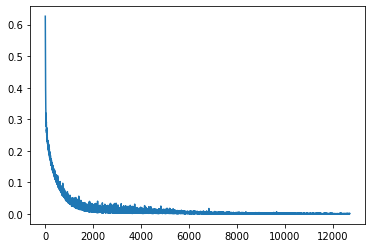

In [165]:
plt.plot(losses)

In [ ]:
plt.plot([metr[0] for metr in metrics_all], label="accuracy")
plt.plot([metr[1] for metr in metrics_all], label= "dice")
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.legend()

In [ ]:
#print(example[0].shape)

for example in examples:
    #print(example[0])
    show_batch_images(example[0],16, "Output")
    show_batch_images(example[1],16, "Label")
    show_batch_images(example[2].type(torch.float32),16, "Input Mask")

In [ ]:
from utils.dice_score import dice_loss
pixel_acc_all = []
dice_all = [] 
precision_all = [] 
specificity_all = [] 
recall_all = []

def test_loop_basic(model, test_dataset):
    computeExample = True
    example = np.zeros((batch_size,64,64))
    example_label = torch.tensor(np.zeros((batch_size,64,64)))
    input_label = None
    for img_before,img_middle,img_after, label_interest,gt_diff_before ,gt_diff_middle in tqdm(test_dataset):
        #img_before = img_before.type(torch.float32).cuda()
        img_middle = img_middle.type(torch.float32).cuda()
        #img_after = img_after.type(torch.float32).cuda()
        label_interest = label_interest.cuda()
        gt_diff_before = gt_diff_middle.cuda()
        with torch.no_grad():
            #sig = torch.nn.Sigmoid()
            
            output = model(torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))
            out_mask = output

        final_mask = out_mask.cpu()
        
        pixel_acc, dice, precision, specificity, recall = metric(final_mask,gt_diff_middle.cpu())
        
        pixel_acc_all.append(float(pixel_acc.data.cpu()))
        dice_all.append(float(dice.data.cpu()))
        precision_all.append(float(precision.data.cpu()))
        specificity_all.append(float(specificity.data.cpu()))
        recall_all.append(float(recall.data.cpu()))

        # compute example
        if computeExample:
            sig = torch.nn.Sigmoid()
            final_mask = sig(final_mask)
            final_mask = final_mask.cpu().detach().numpy()
            
            example = np.zeros_like(final_mask)
            #print("----")
            #print(example.shape)
            example[final_mask>0.5] = 1
            computeExample = False
            example_label = gt_diff_middle.unsqueeze(1).cpu()
            input_label = label_interest.unsqueeze(1).cpu()

        
    means = [np.mean(pixel_acc_all), np.mean(dice_all), np.mean(precision_all), np.mean(specificity_all),np.mean(recall_all)]
    print(f"Pixel acc {means[0]}; Dice {means[1]}; Precision {means[2]}; Specifity {means[3]}; Recall{means[4]}")
    #print(example.shape)
    #print("dwd")
    return means, torch.tensor(example), example_label, input_label
        


In [ ]:
basic_model = UNet(4,1).cuda()

#model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)
#optimizer = torch.optim.SGD(model.parameters(),
#                            lr=1e-3,
#                            momentum=4e-5,
#                            weight_decay=0.9)
optimizer = torch.optim.RMSprop(basic_model.parameters(), lr=1e-5, weight_decay=1e-8, momentum=0.9)

In [ ]:
#loss_function = torch.nn.MSELoss().cuda() # 
loss_function = torch.nn.BCEWithLogitsLoss().cuda()
losses_basic = []
examples_basic = []
metrics_all_basic = []

In [168]:

epoch = 50
for e in range(epoch):
    basic_model.train()
    print(f"epoch {e}")
    iters = 0
    losses_epoch_basic = []
    for img_before,img_middle,img_after, label_interest,gt_diff_before, gt_diff_middle in tqdm(train_loader):
        # img_before = img_before.type(torch.float32).cuda()
        img_middle = img_middle.type(torch.float32).cuda()
        label_interest = label_interest.cuda()
        gt = gt_diff_middle.cuda().unsqueeze(1).type(torch.float32)
       
        output = basic_model(torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))
        # something is wrong with dice loss
        loss = loss_function(output,gt) #+ dice_loss(F.softmax(output, dim=1).float(),gt, multiclass=False)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_epoch_basic.append(float(loss))
        if iters%100 == 0:
            #print(float(loss))
            pass
        iters += 1

    print(f"Running testing - average loss across epoch: {np.mean(losses_epoch_basic)}")
    losses_basic = np.append(losses_basic, losses_epoch_basic)
    basic_model.eval()
    metrics, example, example_label, input_label = test_loop_basic(basic_model,test_loader)
    print(example_label.shape)
    print(example.shape)
    examples_basic.append((example,example_label,input_label))
    metrics_all_basic.append(metrics)
    #show_batch_images(example,16)
    #show_batch_images(example_label,16)

epoch 0


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.004551350101498579


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9904215534140045; Dice 0.6964954188585603; Precision 0.7338032656407449; Specifity 0.9957370827129731; Recall0.6879713321983392
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 1


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.00419944724962702


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9904450637345411; Dice 0.6976813481196164; Precision 0.7343607235756912; Specifity 0.9957399270212164; Recall0.689288973020067
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 2


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0039920909797743435


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9904707639664412; Dice 0.6990235079403232; Precision 0.7350448269676417; Specifity 0.9957440293207764; Recall0.6908082896569562
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 3


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0038196676012905917


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9904943535506141; Dice 0.7000757341827549; Precision 0.7355658861845001; Specifity 0.9957497617704612; Recall0.6919333331894828
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 4


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0036009439009637755


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9905177074341247; Dice 0.7011526788967456; Precision 0.7362588852411136; Specifity 0.9957538360299972; Recall0.6929813382095625
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 5


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0034733741291189993


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9905395318033561; Dice 0.7021424308161981; Precision 0.73646724455164; Specifity 0.995752736539492; Recall0.6943729440511015
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 6


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0031607669373006214


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9905584922267331; Dice 0.703344711891342; Precision 0.7363161621184123; Specifity 0.9957345009057058; Recall0.6966271006627943
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 7


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0031500564545290325


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9905780554495075; Dice 0.7042057380035529; Precision 0.7368061007677832; Specifity 0.995738324014978; Recall0.6974799638195645
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 8


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0029705138230791653


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906002636666277; Dice 0.7052175906842051; Precision 0.7372023530354325; Specifity 0.9957380573531347; Recall0.6987440411222471
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 9


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.002794839056322395


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906157489147103; Dice 0.7061006756815741; Precision 0.7376088439486921; Specifity 0.995740322657583; Recall0.6997317427757707
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 10


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0025929015773297178


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906334582202393; Dice 0.7070638946183034; Precision 0.7377361091223128; Specifity 0.9957342320924689; Recall0.7011986113848522
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 11


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0026296665044098096


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906501618482298; Dice 0.7078984404982913; Precision 0.7379844451907202; Specifity 0.9957323385939255; Recall0.702287062505813
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 12


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0024802238069929357


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906679531559348; Dice 0.7086898170681057; Precision 0.73820668712724; Specifity 0.9957328573800623; Recall0.703345943623052
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 13


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0022908757806491607


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906833331848754; Dice 0.7096327763071567; Precision 0.7384459027852558; Specifity 0.9957267035287424; Recall0.7046718744977732
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 14


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.002213741811936516


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906992824868329; Dice 0.7104855086013923; Precision 0.7387347059369448; Specifity 0.9957247683778405; Recall0.7057885293357468
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 15


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.001998911864732898


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907132216566612; Dice 0.7110953212100133; Precision 0.7390086059754212; Specifity 0.9957296520116783; Recall0.7064762341143744
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 16


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0019434244662072276


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907263868080918; Dice 0.71181838135433; Precision 0.7392969402935705; Specifity 0.9957293157931417; Recall0.7073310750788226
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 17


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.002023295343782034


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907398686959193; Dice 0.7123644672296375; Precision 0.7396390307336472; Specifity 0.9957346885823286; Recall0.7078022766074455
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 18


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.001752316061678658


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907533601208618; Dice 0.7128957951347719; Precision 0.7401248156728054; Specifity 0.9957420552488078; Recall0.708141860333822
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 19


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0017008447641961454


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.99076982921184; Dice 0.7137320722458308; Precision 0.7404792282049224; Specifity 0.9957416269427805; Recall0.7091818410253934
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 20


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0016667874450667021


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907830748707056; Dice 0.7143120607598966; Precision 0.7407075570937356; Specifity 0.9957436352475163; Recall0.7098761017041092
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 21


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0015913464830671327


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907965072687122; Dice 0.7148266027551422; Precision 0.7410411192171708; Specifity 0.9957488501525443; Recall0.71034577496362
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 22


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0014895689258934916


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.990811106136867; Dice 0.7156284743352668; Precision 0.7415848563757859; Specifity 0.9957523168729884; Recall0.7111759906305934
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 23


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.001413596133558505


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9908229113412155; Dice 0.7161627707732192; Precision 0.7418928128194956; Specifity 0.9957552644306086; Recall0.7116982237911904
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 24


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0014234215844290581


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.990835748742231; Dice 0.7167713547401758; Precision 0.7422159602800902; Specifity 0.9957568091081662; Recall0.7123714148575159
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 25


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0014884328370176872


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9908434315138075; Dice 0.7171930959286966; Precision 0.7425256150978783; Specifity 0.9957618671788336; Recall0.712748675537347
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 26


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0012440076791067189


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.990854279943616; Dice 0.7176498183695657; Precision 0.7430098290316056; Specifity 0.9957699391336458; Recall0.7130011590641825
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 27


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.001250543329345913


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9908661093066136; Dice 0.7180904401557651; Precision 0.7434036601769427; Specifity 0.9957761344561974; Recall0.7133121140987801
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 28


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0012251175244523975


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9908754299149701; Dice 0.7186146628471392; Precision 0.7437444572569802; Specifity 0.9957795230377662; Recall0.7138185379968983
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 29


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.00114487811320784


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.990886085291768; Dice 0.7192388942989636; Precision 0.7439610636793077; Specifity 0.9957785861832755; Recall0.7146425847536101
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 30


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0011385394918904676


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9908921698060555; Dice 0.7197492356882079; Precision 0.7440586772281677; Specifity 0.9957725383245792; Recall0.715364533852989
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 31


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0010863028768739685


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9909012028829584; Dice 0.7202657229365622; Precision 0.7442214086922947; Specifity 0.9957721653052524; Recall0.7160647845995509
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 32


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.00101752601464015


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9909085241146386; Dice 0.7206988844524144; Precision 0.7443541900662239; Specifity 0.9957720646169037; Recall0.7166165412814476
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 33


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0009908866277972867


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9909176977098356; Dice 0.7212240081020166; Precision 0.7446590930763862; Specifity 0.9957748669671056; Recall0.7171736844059795
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 34


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0008793119761651001


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9909249443515409; Dice 0.7216950490268453; Precision 0.7447691186069988; Specifity 0.9957722552211546; Recall0.7178239798256107
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 35


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0009809444602542213


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.990933043231447; Dice 0.7219842714284025; Precision 0.7451880152943173; Specifity 0.9957809738859714; Recall0.7178777208027646
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 36


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0009529241557805029


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9909399065543854; Dice 0.7224364346750973; Precision 0.7454385030959245; Specifity 0.9957819099626726; Recall0.7183492333309927
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 37


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0007898315584963539


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9909479202154805; Dice 0.7227430469601476; Precision 0.7457092388313921; Specifity 0.995786766423022; Recall0.7185564996294351
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 38


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0007803484322649874


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.990956254844922; Dice 0.7230324241369103; Precision 0.746134739710278; Specifity 0.9957941712941542; Recall0.7185792559273652
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 39


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0008039091068400643


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9909631229894257; Dice 0.7233880031183367; Precision 0.7463366078994312; Specifity 0.9957952145701168; Recall0.7189378139737289
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 40


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0006530527982793888


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9909713526722044; Dice 0.7237136719127784; Precision 0.7466910090244544; Specifity 0.995800223138014; Recall0.7190941083406799
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 41


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0006934912951147976


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9909809655352925; Dice 0.7243138673488851; Precision 0.7468413389706461; Specifity 0.9957967944066511; Recall0.7200028304212488
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 42


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0007292364138351776


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9909877115032739; Dice 0.7246152871778447; Precision 0.7469872978153742; Specifity 0.9957986576482654; Recall0.7203325364689965
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 43


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0007692022477349956


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.990993695722504; Dice 0.7249254581829191; Precision 0.7470400081384558; Specifity 0.9957978084355921; Recall0.7207903841482682
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 44


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0005847271639527386


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910015513027168; Dice 0.7252418045535203; Precision 0.7474379067704; Specifity 0.9958047956916625; Recall0.7209074614805313
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 45


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0005937176745389056


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910069756129737; Dice 0.7255471029282423; Precision 0.7475841934592413; Specifity 0.9958046950319762; Recall0.7212578084833462
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 46


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0005724319417486114


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910106406685837; Dice 0.7258172132088313; Precision 0.7478541826700514; Specifity 0.9958075169434256; Recall0.7213966442185773
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 47


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0005803971106379465


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910156194512781; Dice 0.7262419839608831; Precision 0.7479831363564651; Specifity 0.9958054084722933; Recall0.721984161588795
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 48


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0006338868541808021


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910220920767946; Dice 0.7265793268038742; Precision 0.7480841019569198; Specifity 0.9958047666974986; Recall0.7224312527641598
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 49


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.000538765367094838


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910258645210991; Dice 0.7268269344870122; Precision 0.7483000221047742; Specifity 0.9958074495734013; Recall0.722583638115575
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])


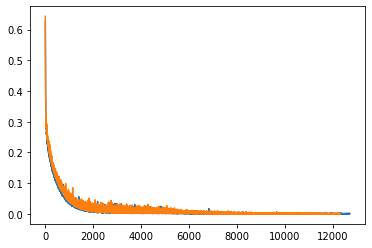

In [169]:
plt.plot(losses)
plt.plot(losses_basic)

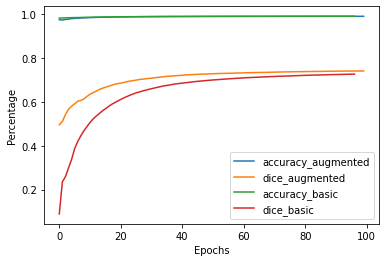

In [170]:
plt.plot([metr[0] for metr in metrics_all], label="accuracy_augmented")
plt.plot([metr[1] for metr in metrics_all], label= "dice_augmented")
plt.plot([metr[0] for metr in metrics_all_basic], label="accuracy_basic")
plt.plot([metr[1] for metr in metrics_all_basic], label= "dice_basic")
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.legend()

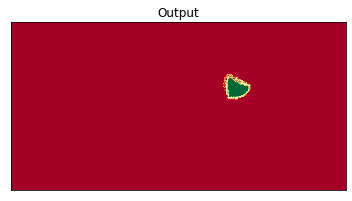

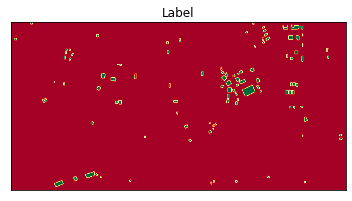

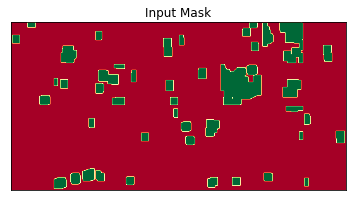

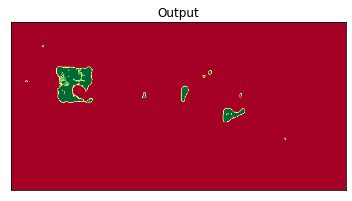

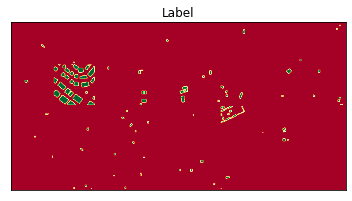

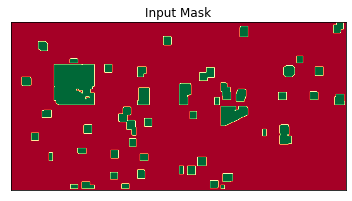

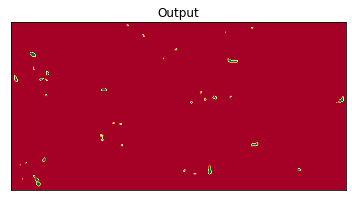

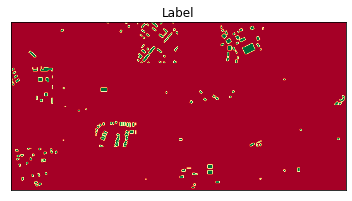

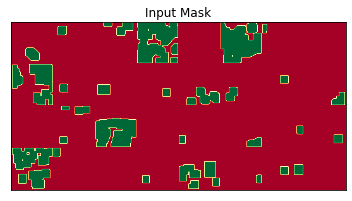

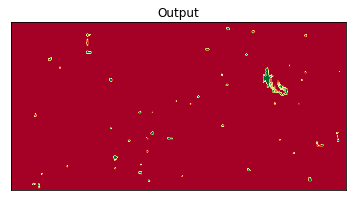

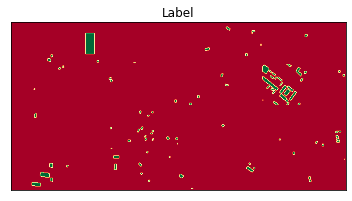

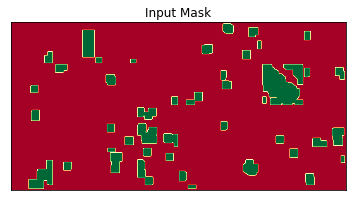

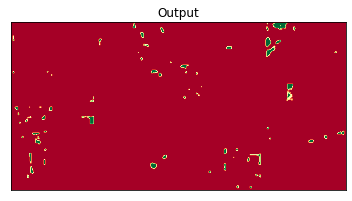

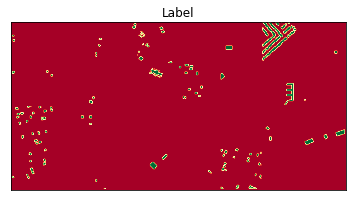

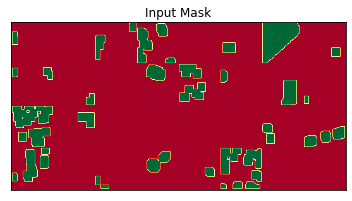

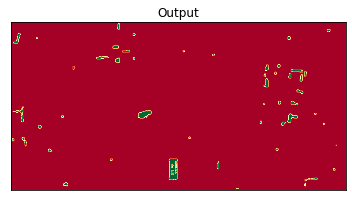

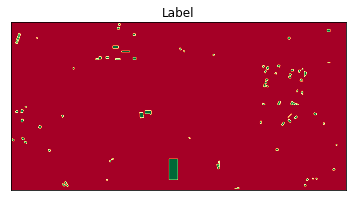

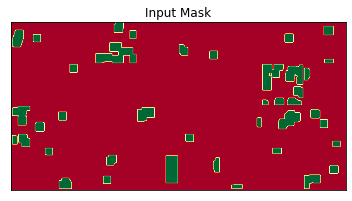

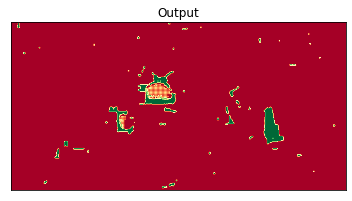

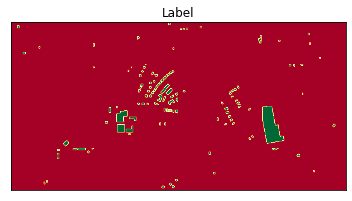

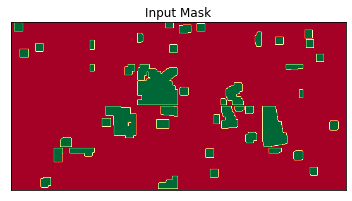

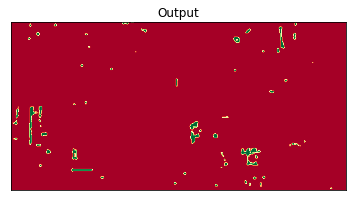

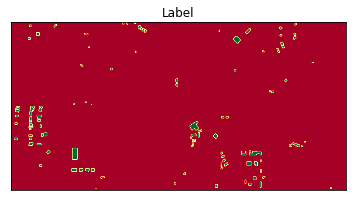

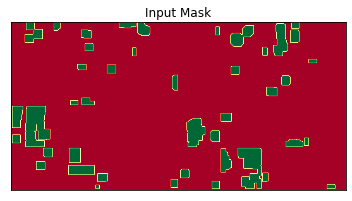

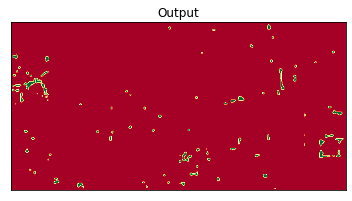

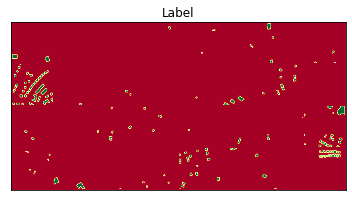

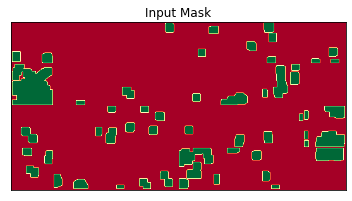

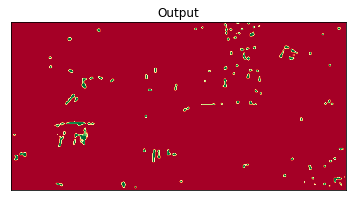

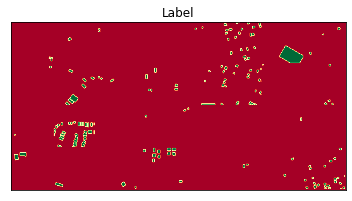

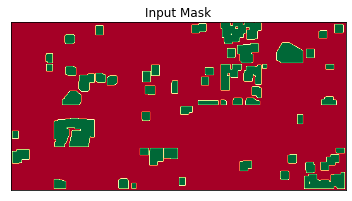

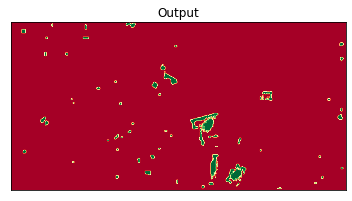

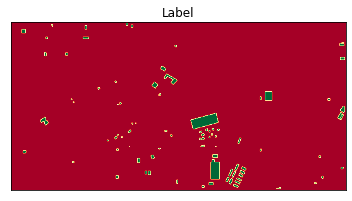

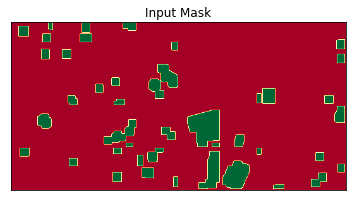

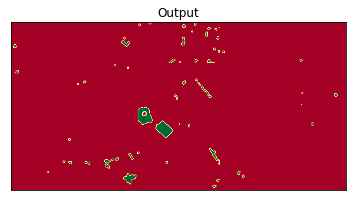

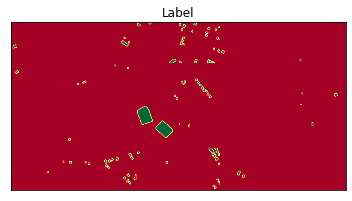

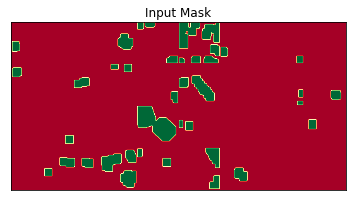

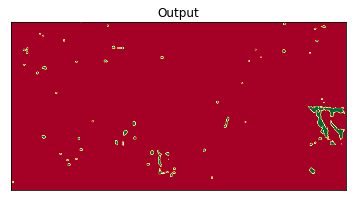

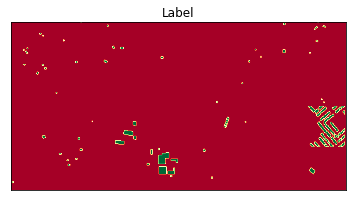

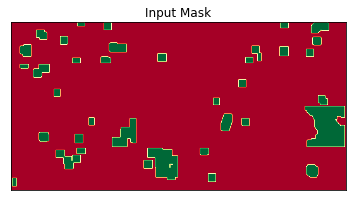

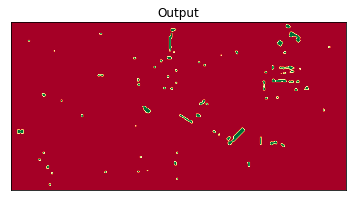

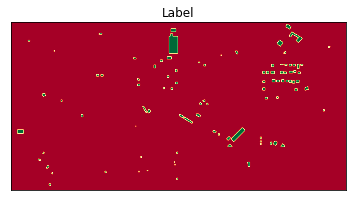

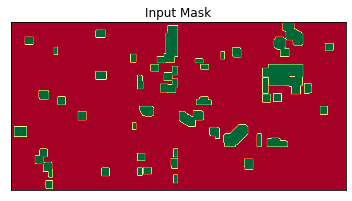

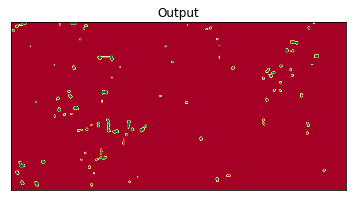

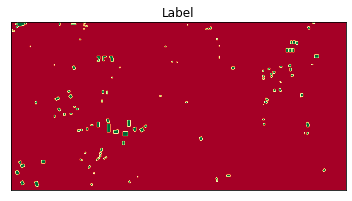

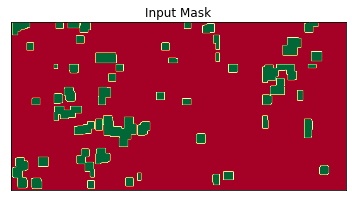

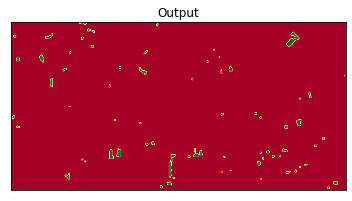

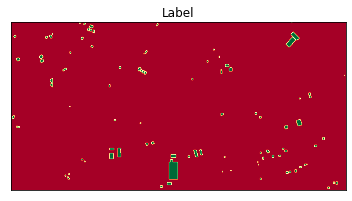

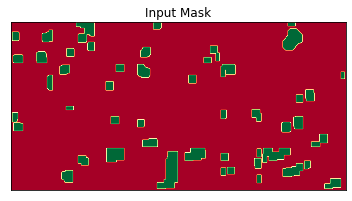

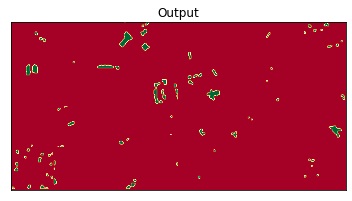

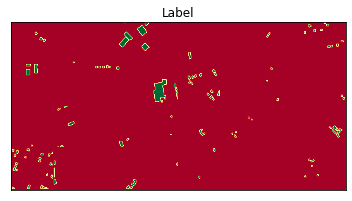

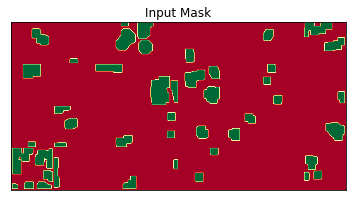

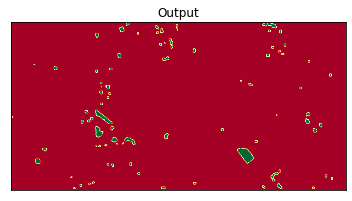

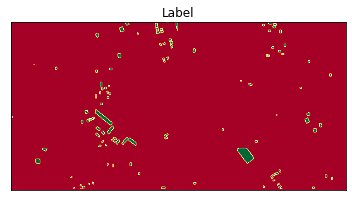

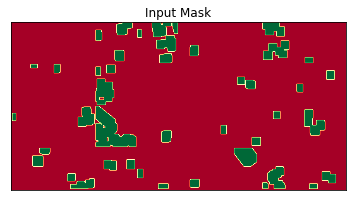

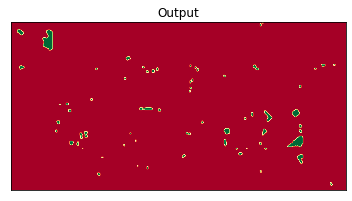

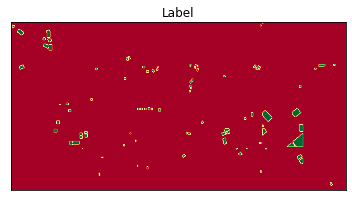

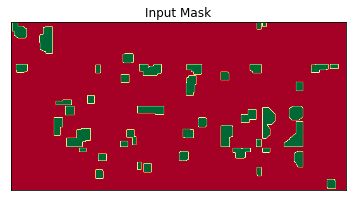

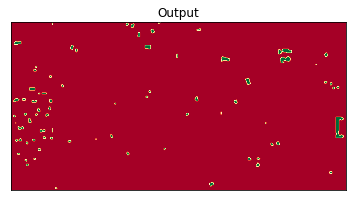

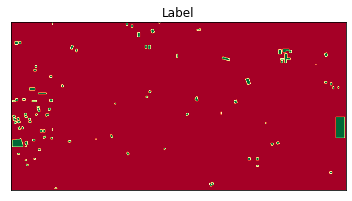

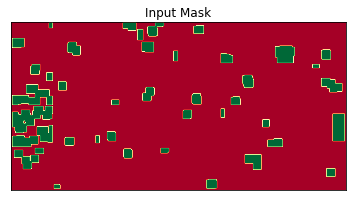

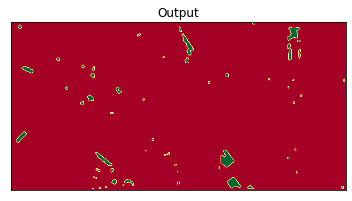

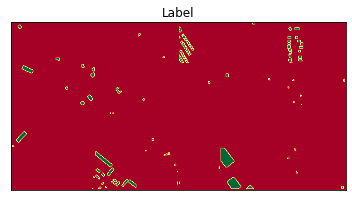

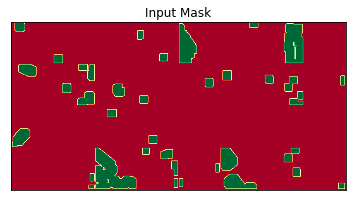

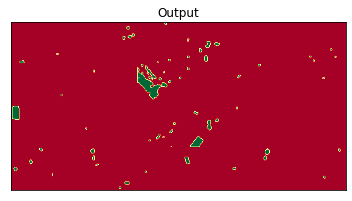

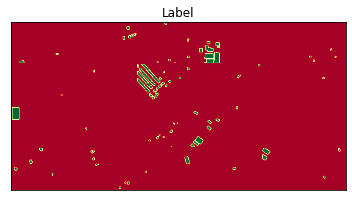

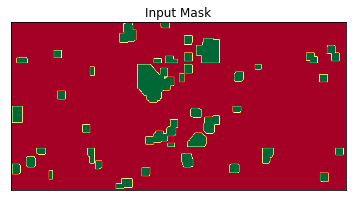

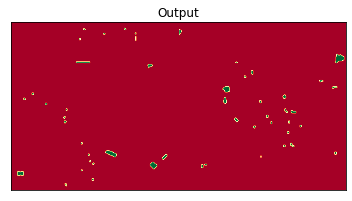

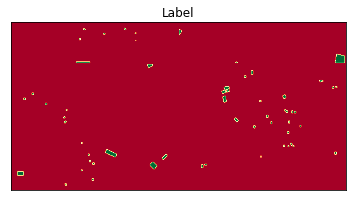

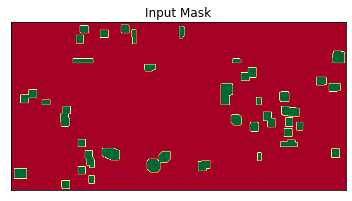

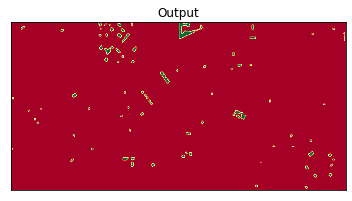

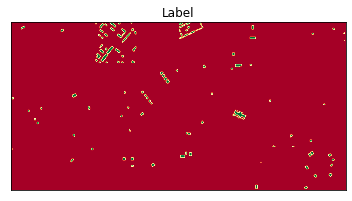

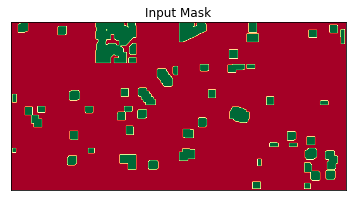

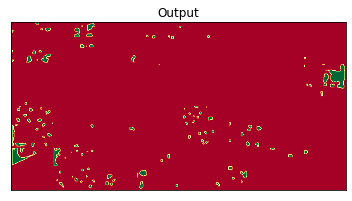

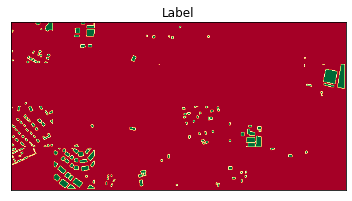

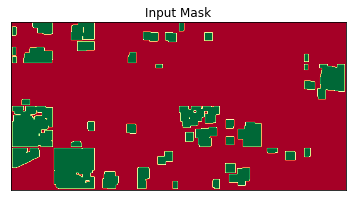

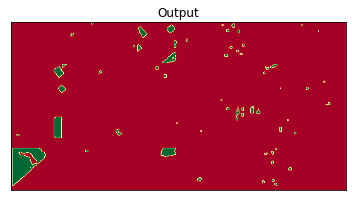

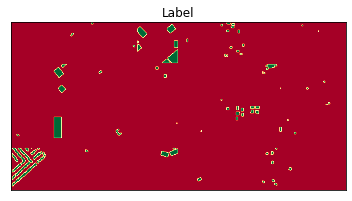

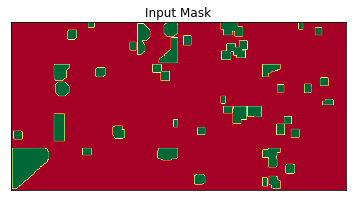

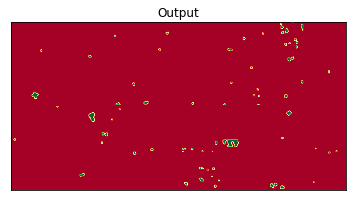

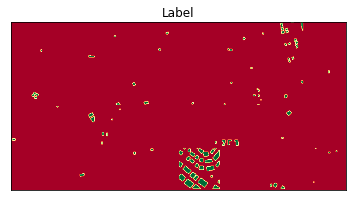

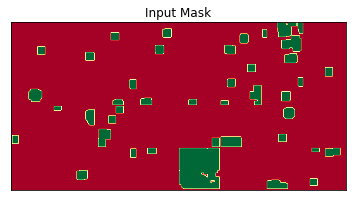

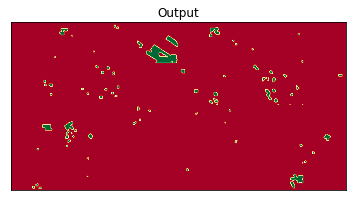

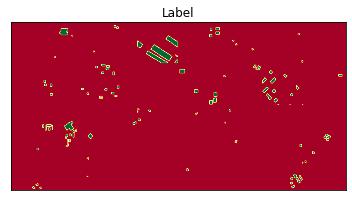

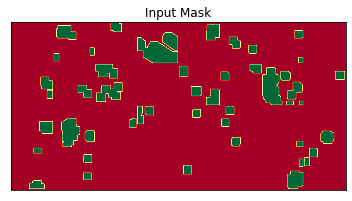

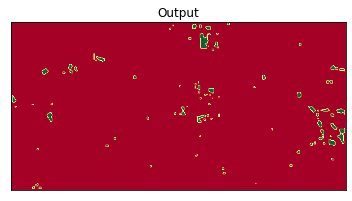

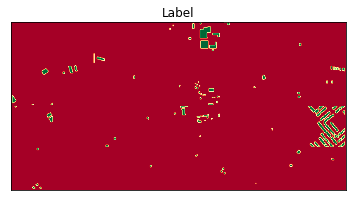

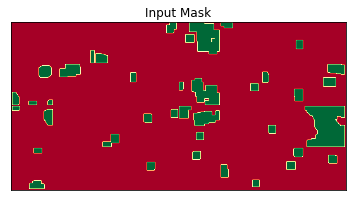

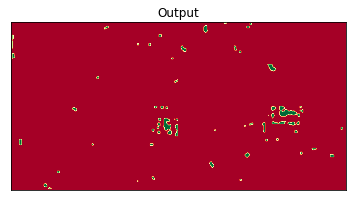

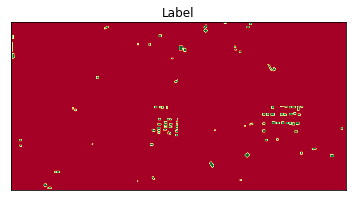

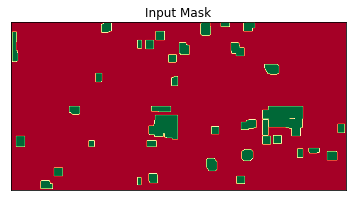

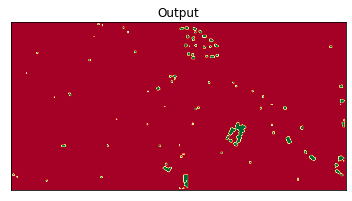

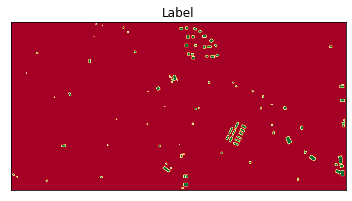

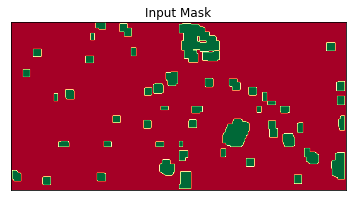

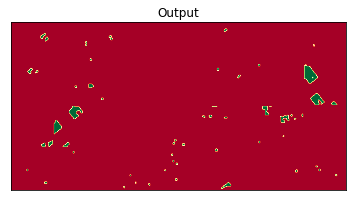

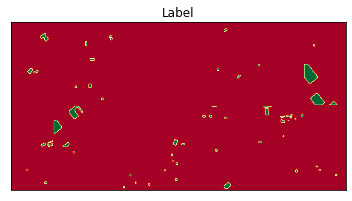

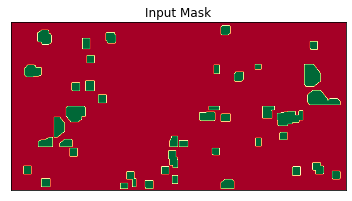

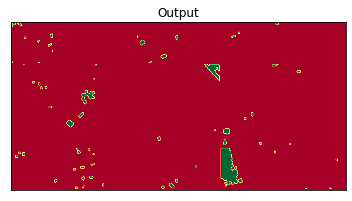

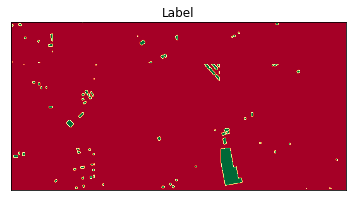

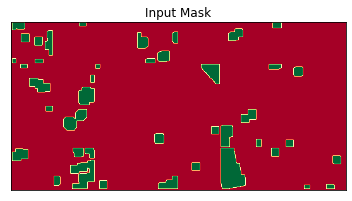

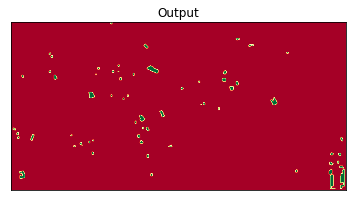

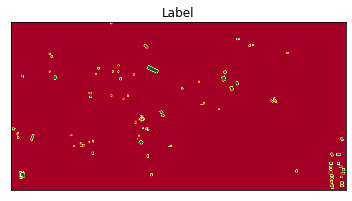

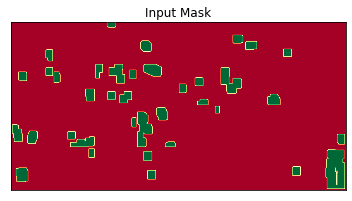

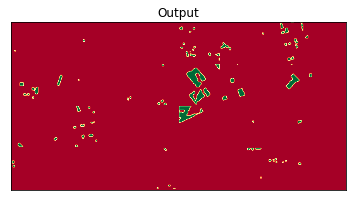

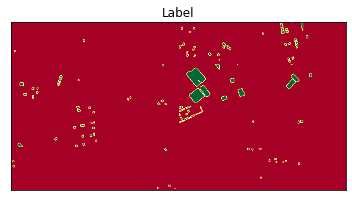

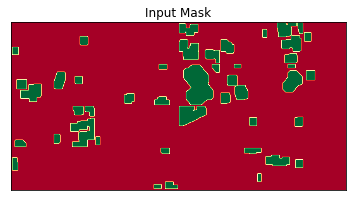

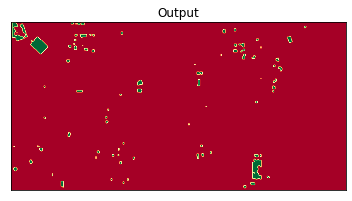

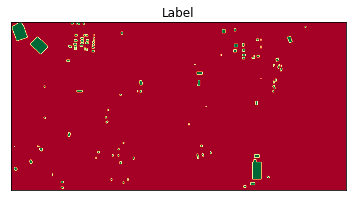

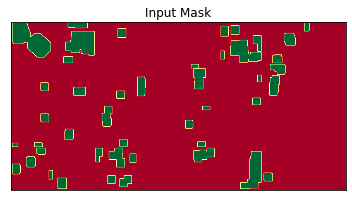

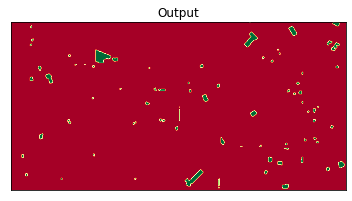

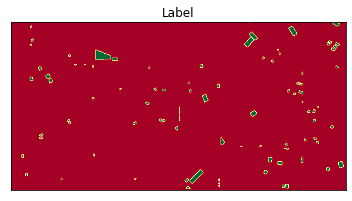

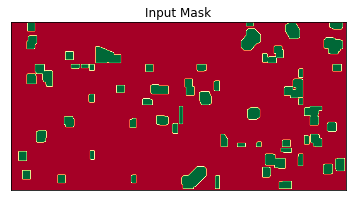

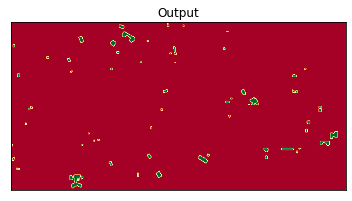

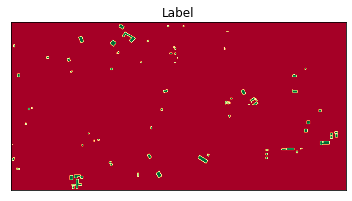

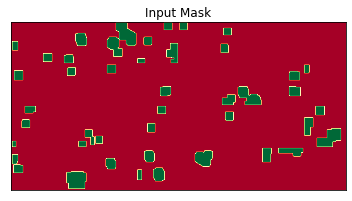

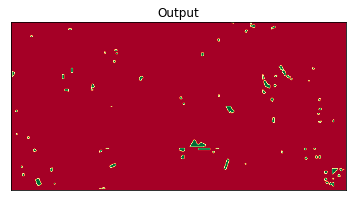

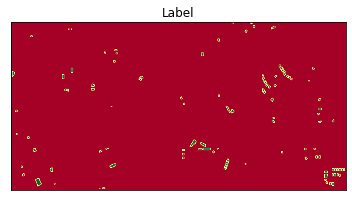

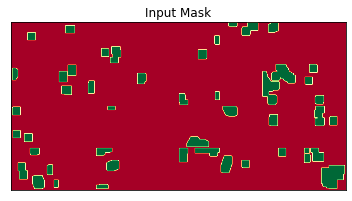

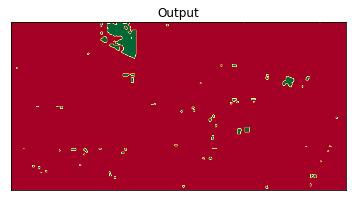

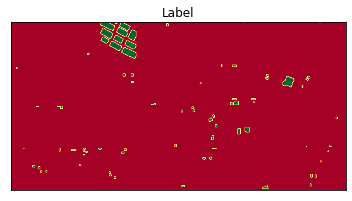

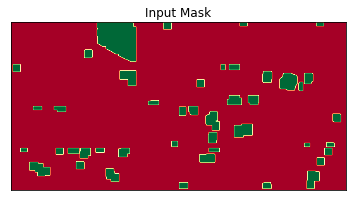

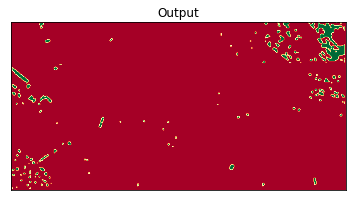

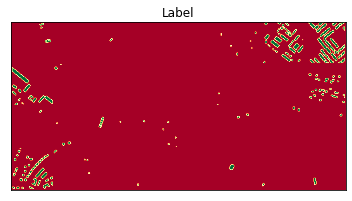

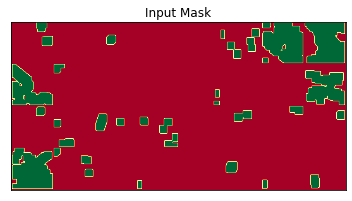

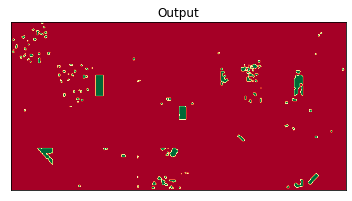

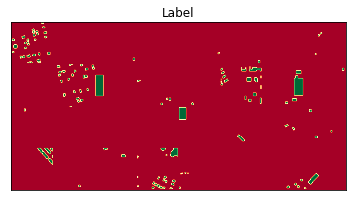

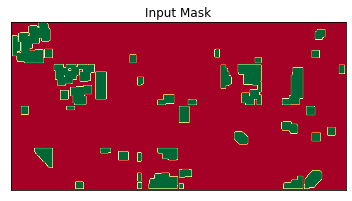

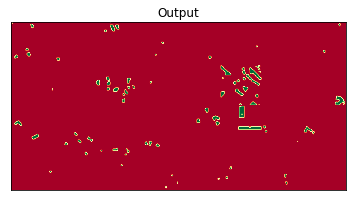

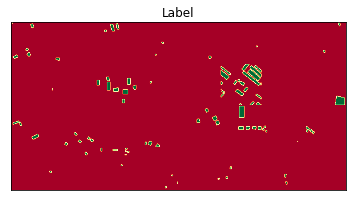

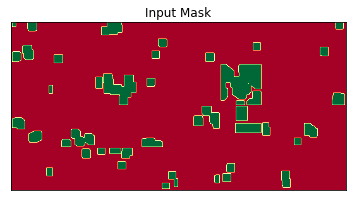

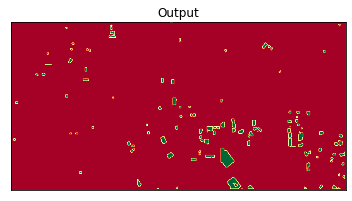

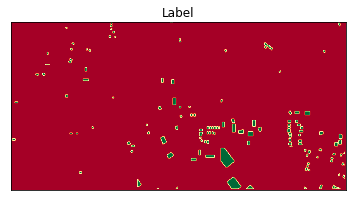

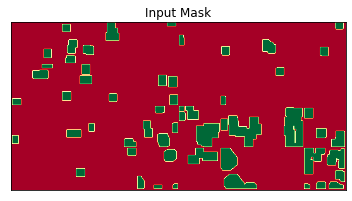

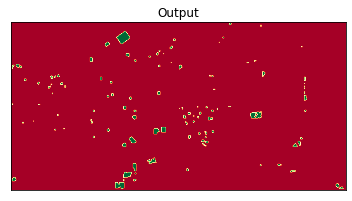

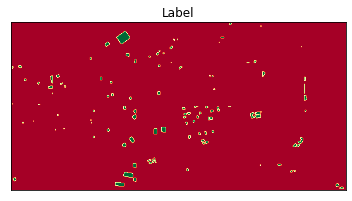

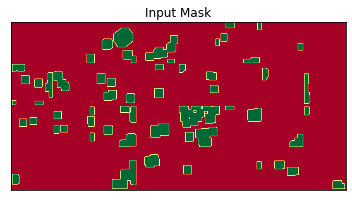

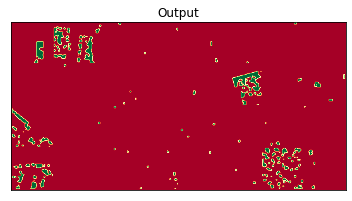

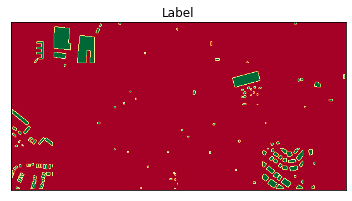

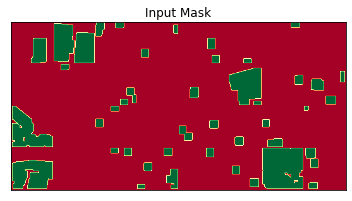

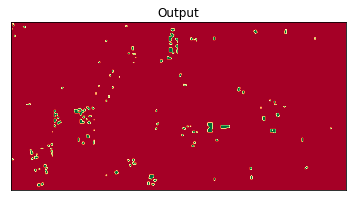

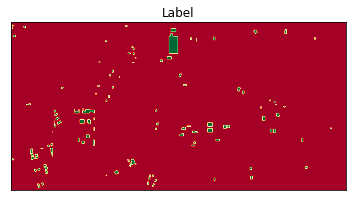

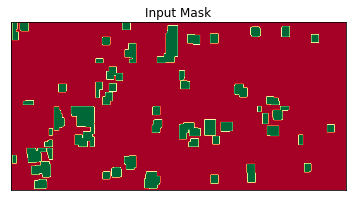

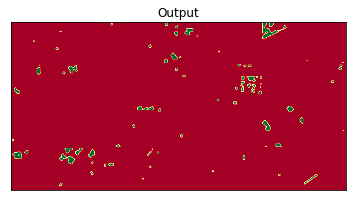

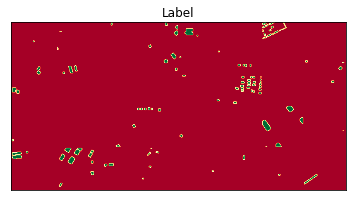

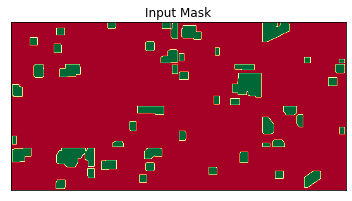

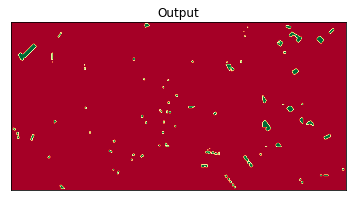

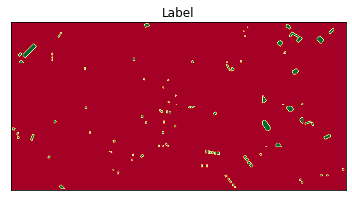

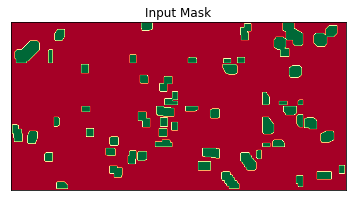

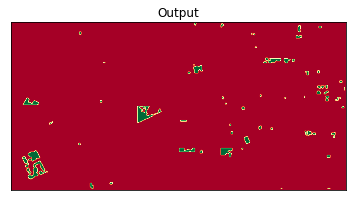

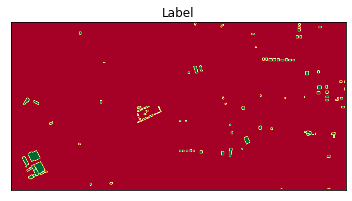

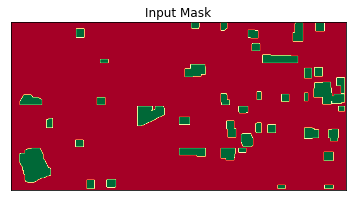

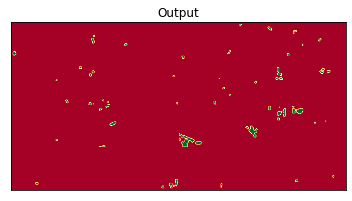

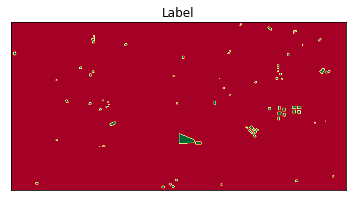

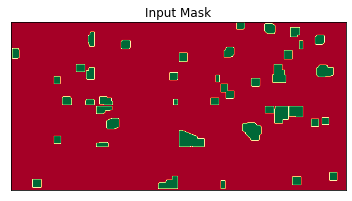

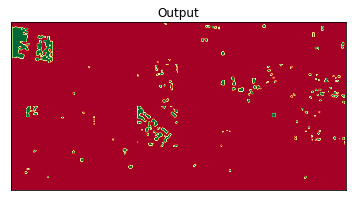

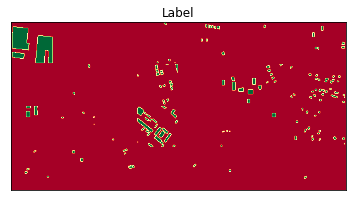

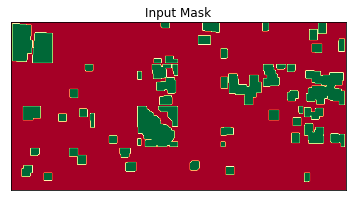

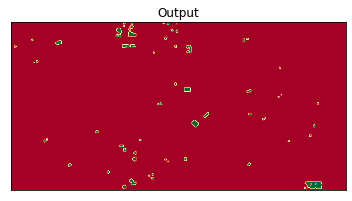

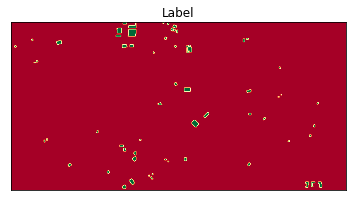

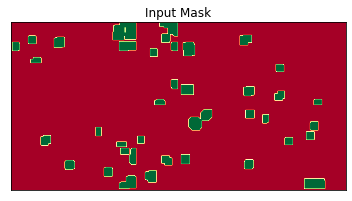

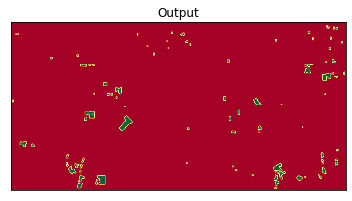

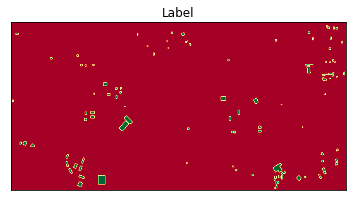

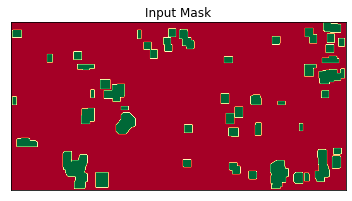

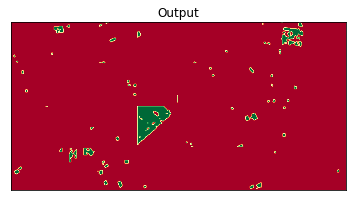

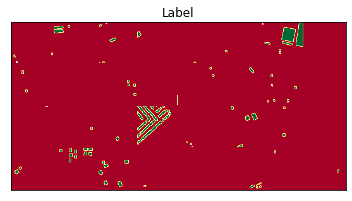

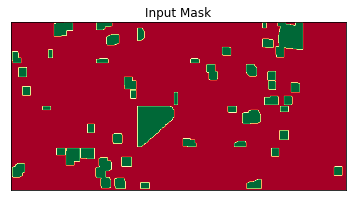

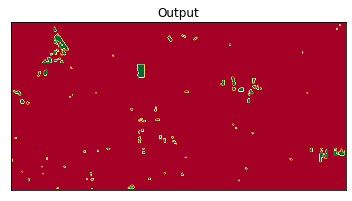

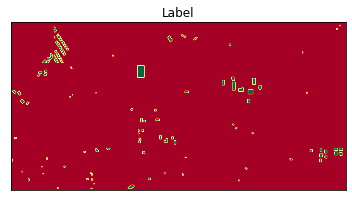

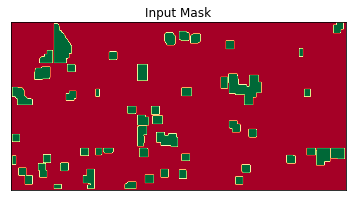

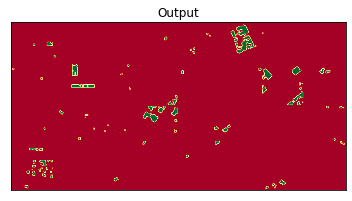

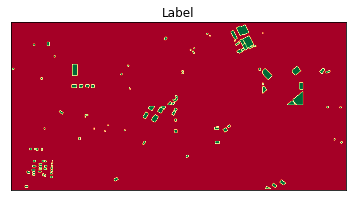

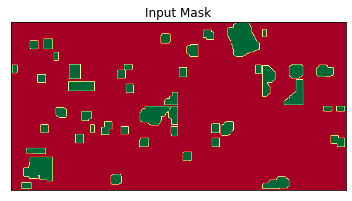

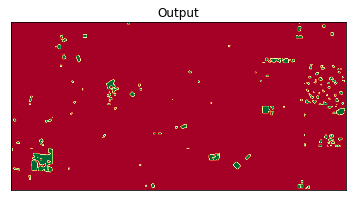

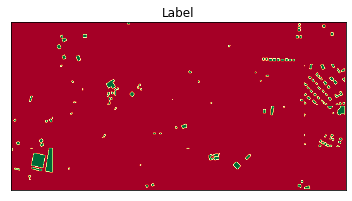

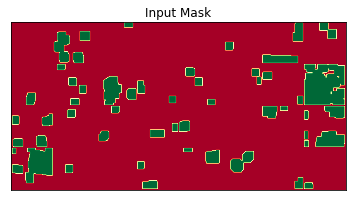

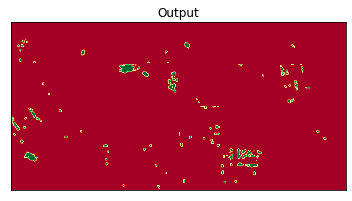

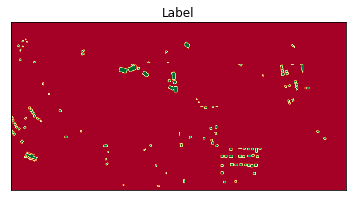

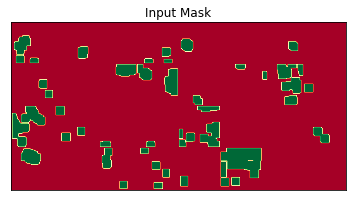

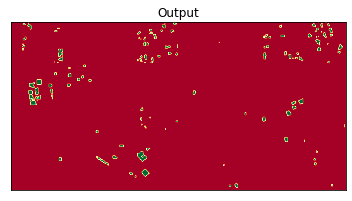

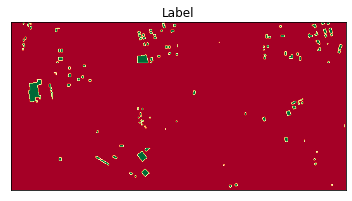

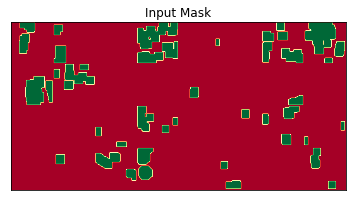

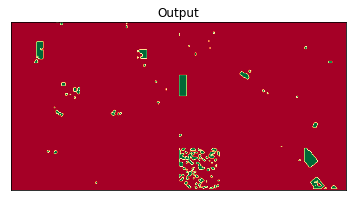

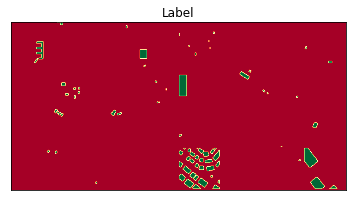

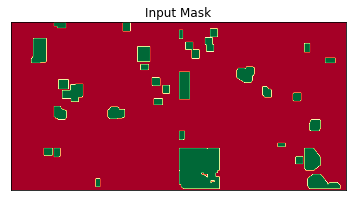

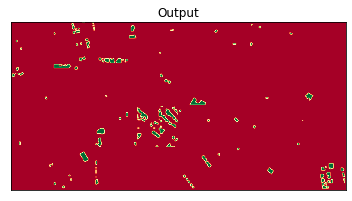

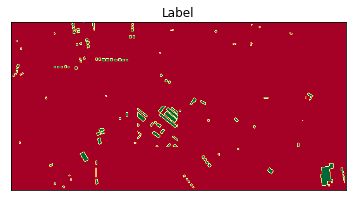

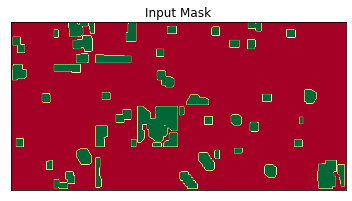

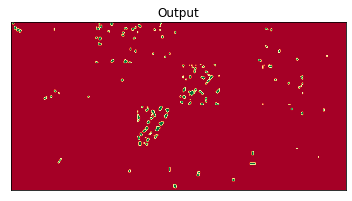

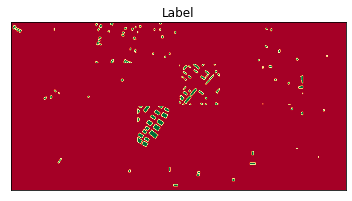

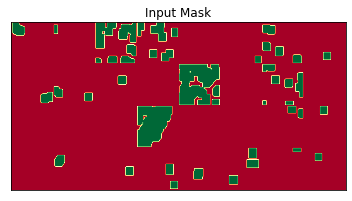

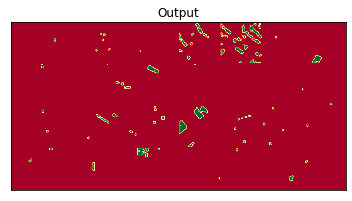

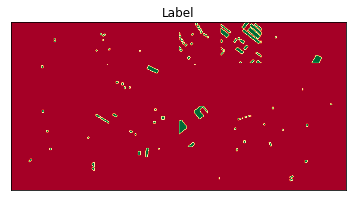

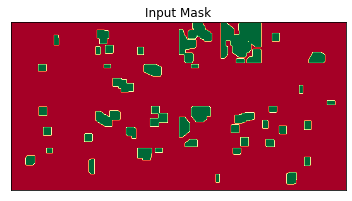

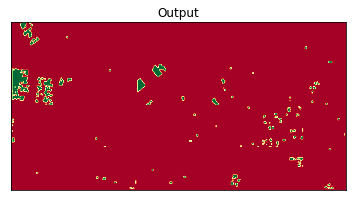

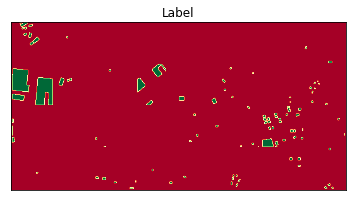

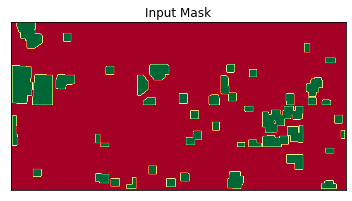

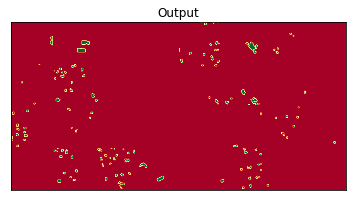

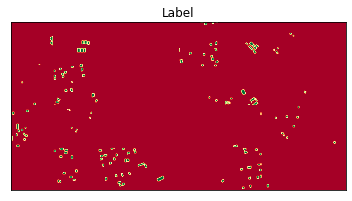

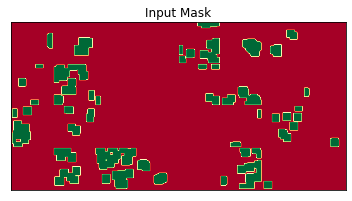

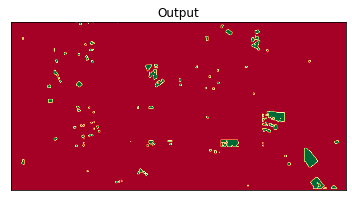

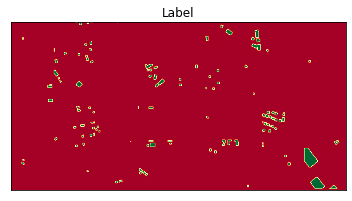

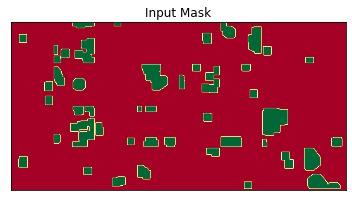

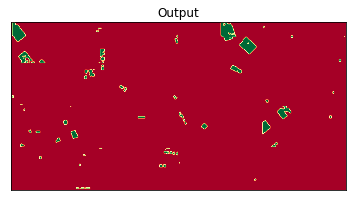

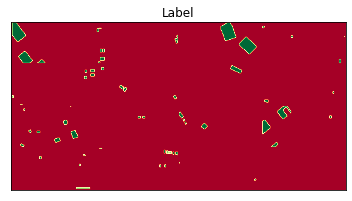

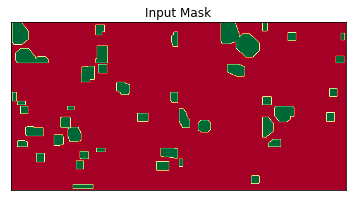

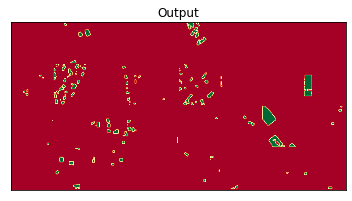

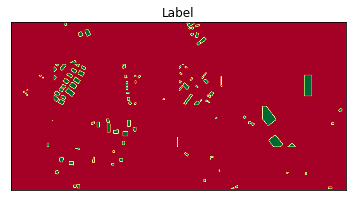

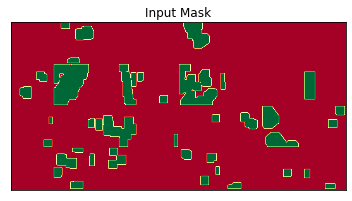

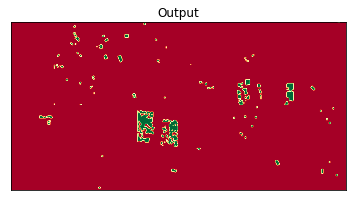

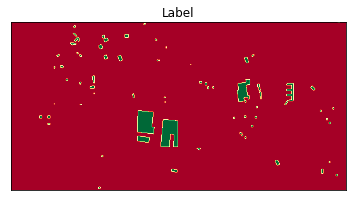

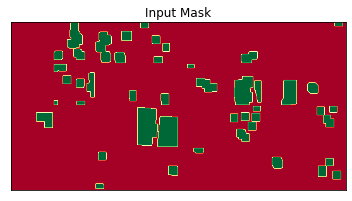

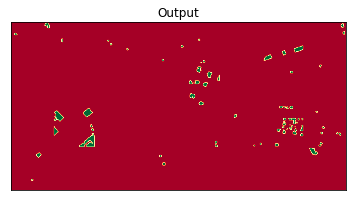

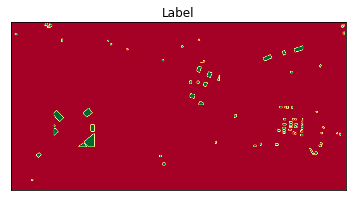

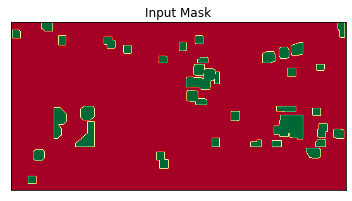

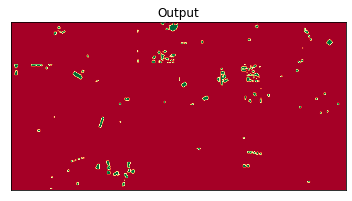

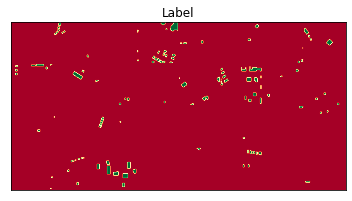

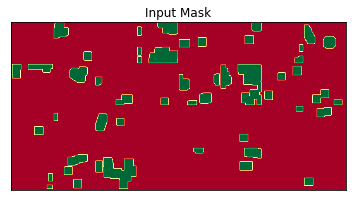

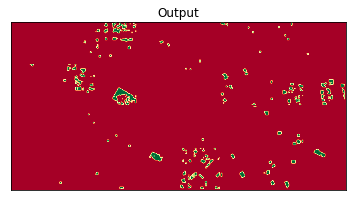

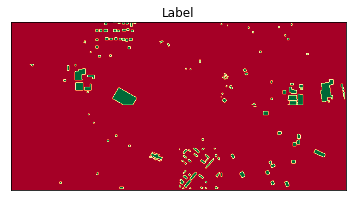

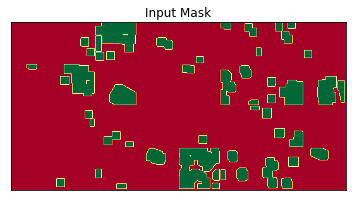

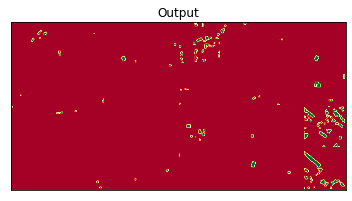

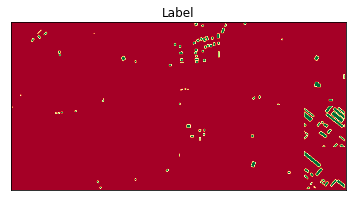

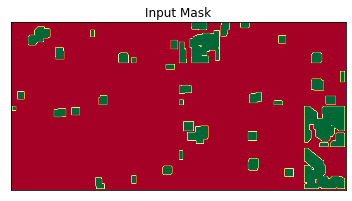

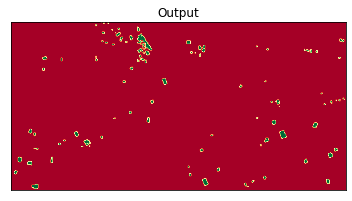

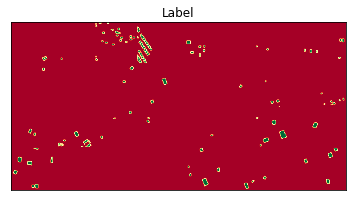

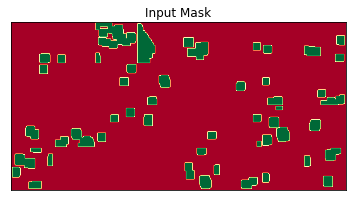

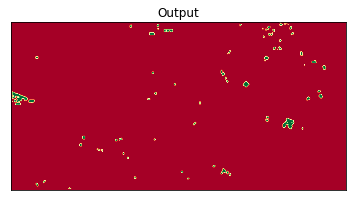

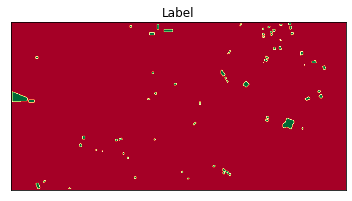

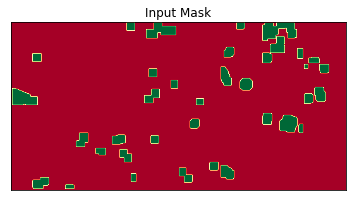

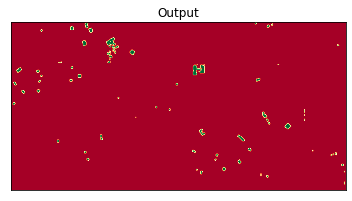

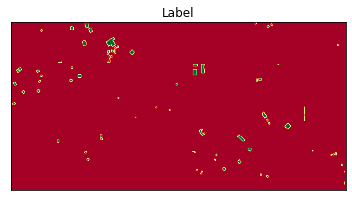

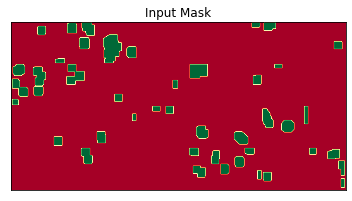

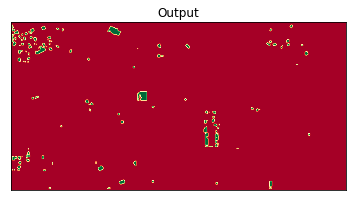

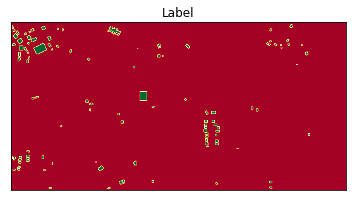

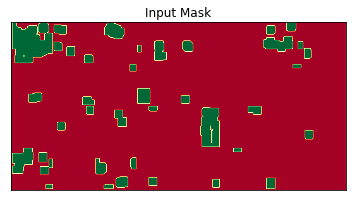

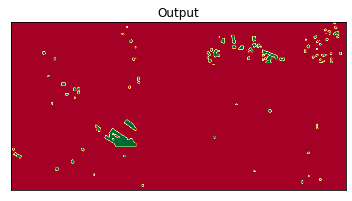

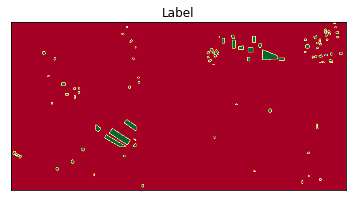

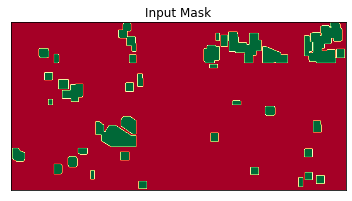

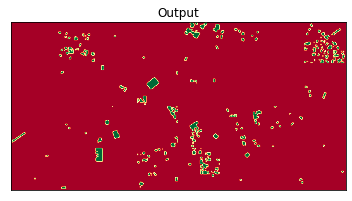

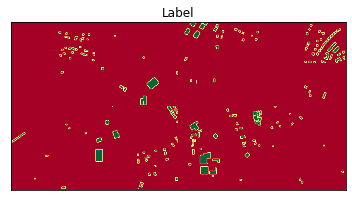

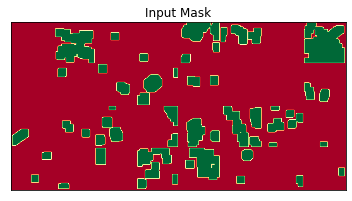

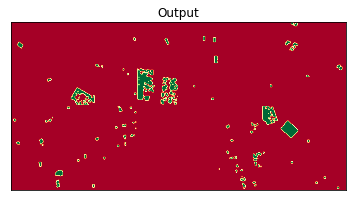

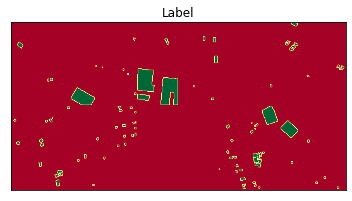

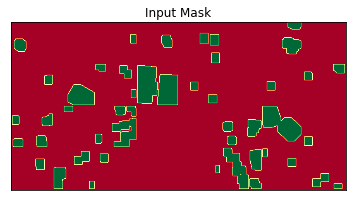

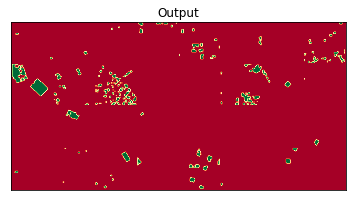

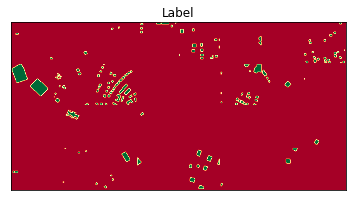

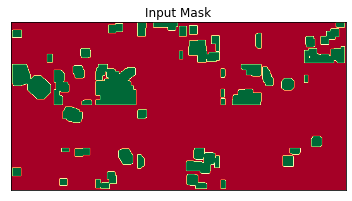

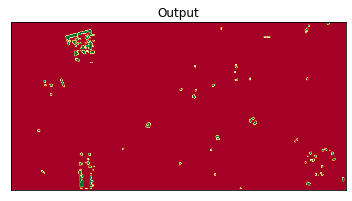

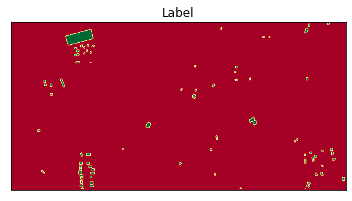

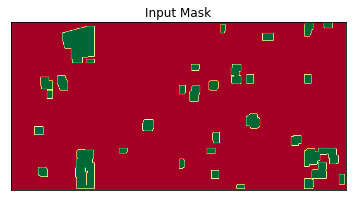

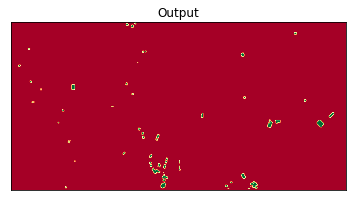

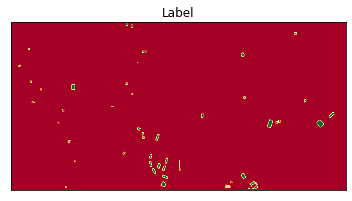

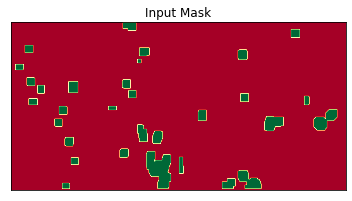

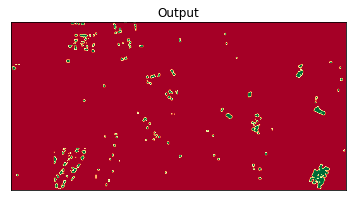

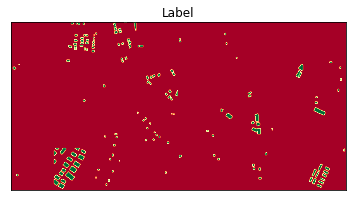

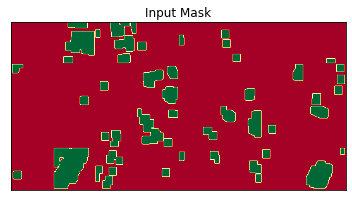

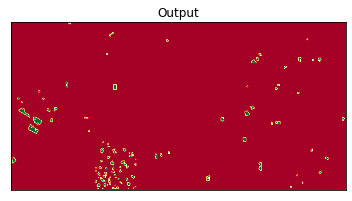

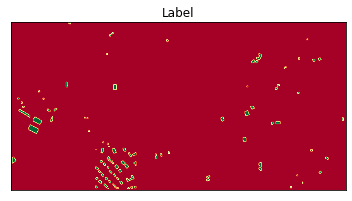

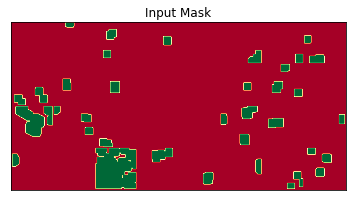

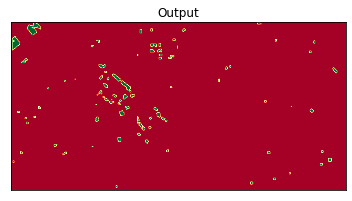

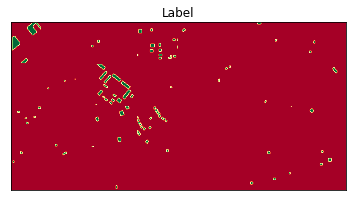

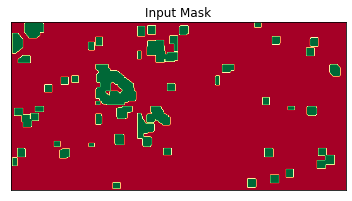

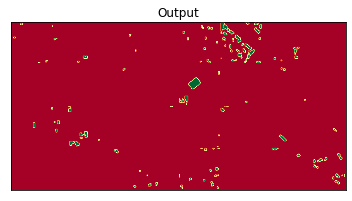

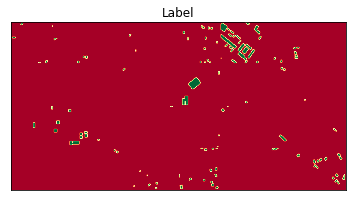

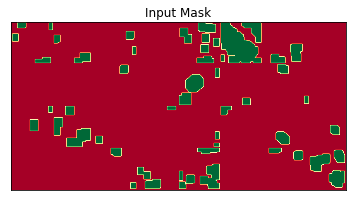

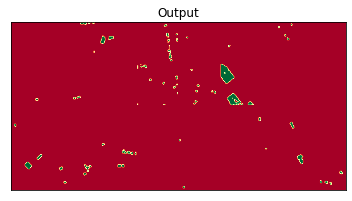

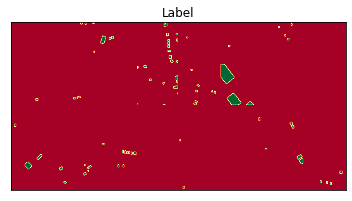

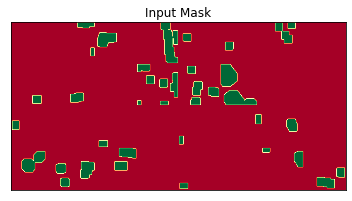

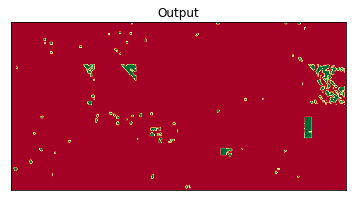

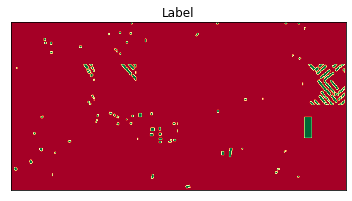

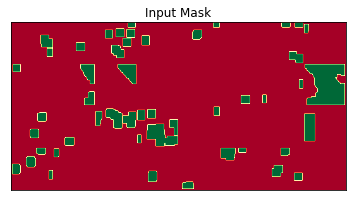

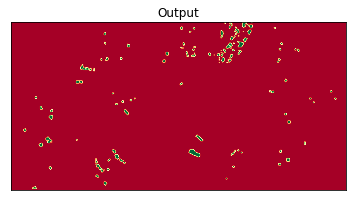

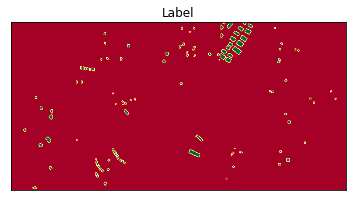

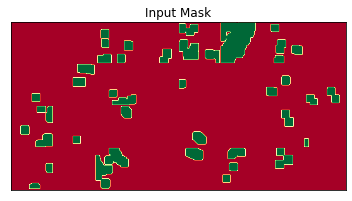

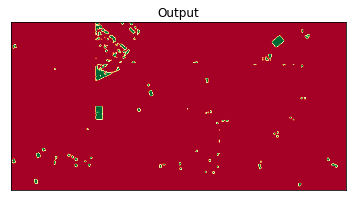

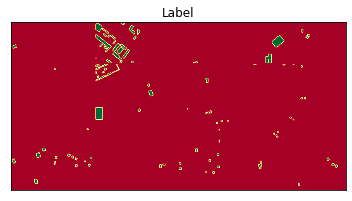

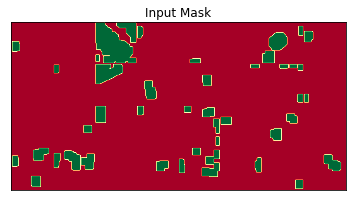

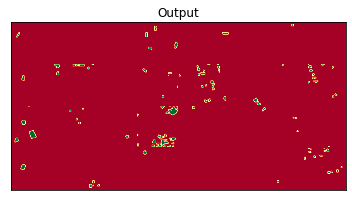

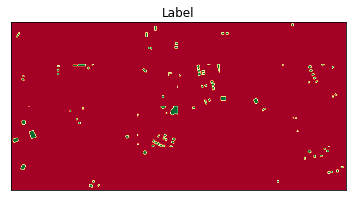

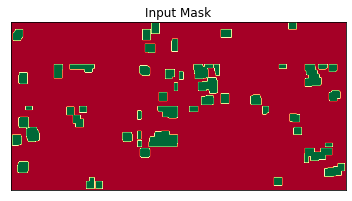

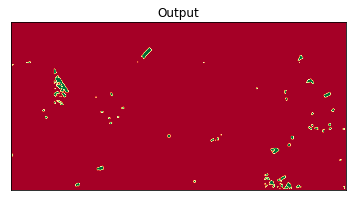

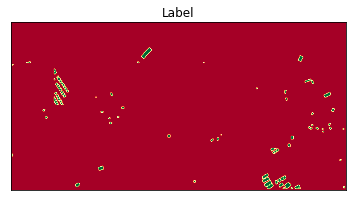

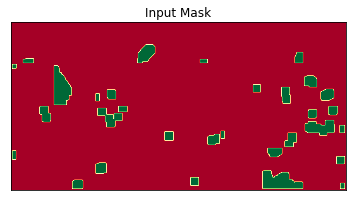

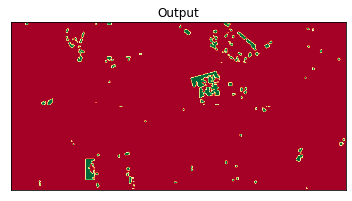

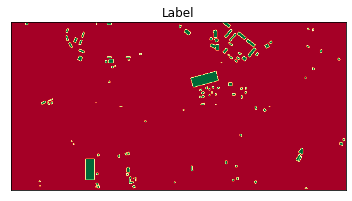

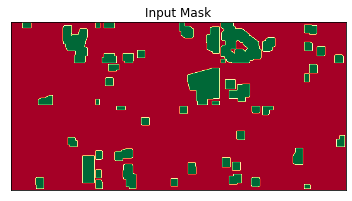

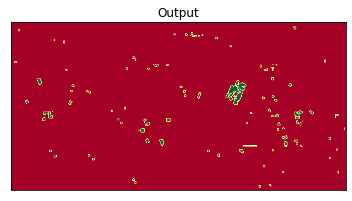

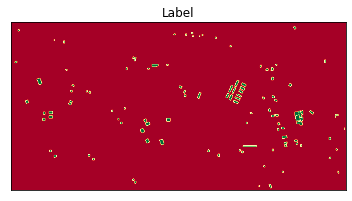

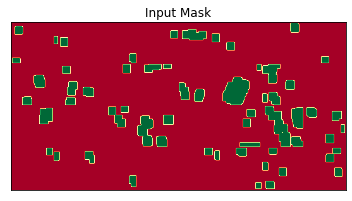

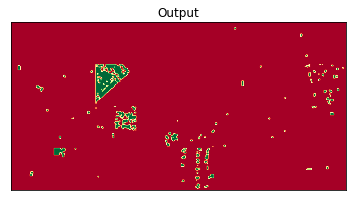

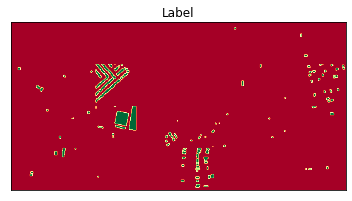

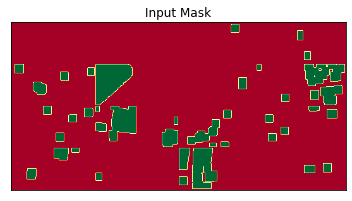

In [171]:
#print(example[0].shape)

for example in examples_basic:
    #print(example[0])
    show_batch_images(example[0],16, "Output")
    show_batch_images(example[1],16, "Label")
    show_batch_images(example[2].type(torch.float32),16, "Input Mask")

In [172]:
# missing evaluation for complete masked input
img_before,img_middle,img_after, label_interest,gt_diff_before, gt_diff_middle = next(iter(train_loader))
label_interest = torch.tensor(np.ones_like(label_interest)).cuda()
img_middle = img_middle.type(torch.float32).cuda()
gt = gt_diff_middle.cuda().unsqueeze(1).type(torch.float32)

output = basic_model(torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))

sig = torch.nn.Sigmoid()
final_mask = sig(output)
final_mask = final_mask.cpu().detach().numpy()

output = np.zeros_like(final_mask)
#print("----")
#print(example.shape)
output[final_mask>0.5] = 1
print(output.shape)

(32, 1, 64, 64)


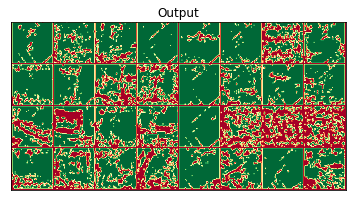

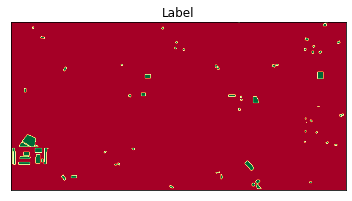

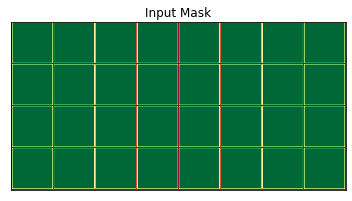

In [173]:
show_batch_images(torch.tensor(output),16, "Output")
show_batch_images(gt.cpu(),16, "Label")
show_batch_images(label_interest.unsqueeze(1).type(torch.float32).cpu().type(torch.float32),16, "Input Mask")

In [174]:
# missing evaluation for complete masked input
img_before,img_middle,img_after, label_interest,gt_diff_before, gt_diff_middle = next(iter(train_loader))
label_interest = torch.tensor(np.ones_like(label_interest)).cuda()
img_middle = img_middle.type(torch.float32).cuda()
img_before = img_before.type(torch.float32).cuda()
gt = gt_diff_middle.cuda().unsqueeze(1).type(torch.float32)

output = model(torch.cat([img_before,label_interest.unsqueeze(1).type(torch.float32)],dim=1),
                     torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))

sig = torch.nn.Sigmoid()
final_mask = sig(output)
final_mask = final_mask.cpu().detach().numpy()

output = np.zeros_like(final_mask)
#print("----")
#print(example.shape)
output[final_mask>0.5] = 1
print(output.shape)

(32, 1, 64, 64)


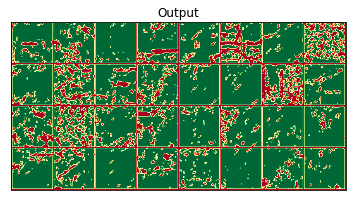

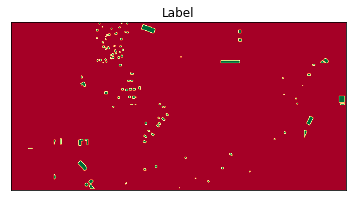

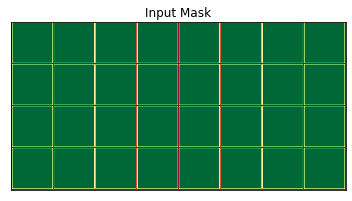

In [175]:
show_batch_images(torch.tensor(output),16, "Output")
show_batch_images(gt.cpu(),16, "Label")
show_batch_images(label_interest.unsqueeze(1).type(torch.float32).cpu().type(torch.float32),16, "Input Mask")